In [3]:

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import scipy.integrate as integrate
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.patches as patches
import random

import MOS_design as MD
import mag_design as MGD
import scipy
from scipy import interpolate
# Default value of display.max_rows is 10 i.e. at max 10 rows will be printed.
# Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', None) #To show all values, not just 5
%matplotlib inline
# %matplotlib widget
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(style="darkgrid")

In [4]:

# MOSFET data
MOSFETs=pd.read_excel(r'.\Space Components.xls',sheet_name="MOSFETs")
# Se usa del siguiente modo:
#MOSFETs['Id (A @25oC)'][54]=70
pd.options.display.max_columns = None
display(MOSFETs.tail(20))


,Part,JEDEC Part,Manufacturer,Type,Vds (V),Id (A @25oC),Id (A @100oC),Rdson (ohms @25oC),Rdson (ohms @125oC),Ciss (pF),Coss (pF),Crss (pF),Qg (nC),Qgs (nC),Qgd (nC),td_on (ns),tr (ns),td_off (ns),tf (ns),Rth jc (oC/W),Rth jPCB (oC/W),Tj_max (oC),Package,Link,NOTES
52,FBS-GAM02-P-R50,NaN,Freebird Semiconductor /EPC Space,3.0,50,10,7.5,0.007,0.01,NP,NP,NP,NP,NP,NP,60,6.5,75,6,8.5,NP,130,18 pin SMT,https://epc.space/documents/datasheets/FBSGAM0...,Half bridge plus driver. Seem to be EPC. Simil...
53,GS66516B,NaN,GaN Systems,2.0,650,60,47,0.025,0.065,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN
54,IXTA26P20P,NaN,IXYS,1.0,200,70,26,0.17,0.34,2740,540,100,56,18,20,18,33,46,21,0.42,0.5,125,NaN,NaN,NaN
55,GS66516B_old1,NaN,GaN Systems,2.0,650,60,47,0.0255,0.0663,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN
56,IXTA26P20P_old1,NaN,IXYS,1.0,200,70,26,0.1734,0.3468,2740,540,100,56,18,20,18,33,46,21,0.42,0.5,125,NaN,NaN,NaN
57,GS66516B_old2,NaN,GaN Systems,2.0,650,60,47,0.026,0.0676,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN
58,IXTA26P20P_old2,NaN,IXYS,1.0,200,70,26,0.1768,0.3536,2740,540,100,56,18,20,18,33,46,21,0.42,0.5,125,NaN,NaN,NaN
59,GS66516B_old3,NaN,GaN Systems,2.0,650,60,47,0.0265,0.0689,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN
60,IXTA26P20P_old3,NaN,IXYS,1.0,200,70,26,0.1802,0.3604,2740,540,100,56,18,20,18,33,46,21,0.42,0.5,125,NaN,NaN,NaN
61,GS66516B_old4,NaN,GaN Systems,2.0,650,60,47,0.027,0.0702,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN


In [3]:
#MOSFETs.loc['GS66516B','Rdson (ohms @25oC)']
#MOSFETs.set_index('Part',inplace=True)

In [4]:
# float(MOSFETs.loc[MOSFETs['Part']=='GS66516B','Rdson (ohms @25oC)'])
# MOSFETs[MOSFETs['Part']=='GS66516B'].index[0]
# MOSFETs.loc[:,'Tj_max (oC)']

# Variables de entrada y configuración

In [5]:
Vbus=100 # Tensión en el bus
Vsa_min=80 #Máximo y minimo de la tensión del panel solar
Vsa_max=150
fsw=180e3 #100000 # Frecuencia de conmutación
T=1/fsw
P=500 # Potencia nominal
L_ind=84/1000000

size_D1=50 #Número de elementos en los vectores de D1 y D2.
size_D2=50

# Estos no son límites de operación, que vienen definidos por las variables de arriba. Estos son límites de representación
# de las gráficas como los mapas de calor.
D1_min_sh=0.1
D1_max_sh=1
D2_min_sh=0.0
D2_max_sh=0.7

D1_nom=0.8
D2_nom=0.1
D1_max=0.95
D2_min=0.05


phi_bob=0 #Desfase entre las señales de gobierno D1 y D2.
Lim_sup_D1=0.95 # Límites máximos de operación de los ciclos de trabajo
Lim_inf_D2=0.05

# MOSFET seleccionados en la implementación, según la tabla importada de Excel.
chosen_FET='GS66516B' 
M1_index=MOSFETs[MOSFETs['Part']==chosen_FET].index[0]
M2_index=MOSFETs[MOSFETs['Part']==chosen_FET].index[0]
M3_index=MOSFETs[MOSFETs['Part']==chosen_FET].index[0]
M4_index=MOSFETs[MOSFETs['Part']==chosen_FET].index[0]
M1prot_index=MOSFETs[MOSFETs['Part']=='IXTA26P20P'].index[0]
M3prot_index=MOSFETs[MOSFETs['Part']=='IXTA26P20P'].index[0]
prot_on=1
#Driver
Vdrvr=9
Idrvr=4

Rca_M1=3.2#based on excel file
Rjc_M1=1.5#MOSFETs.loc[M1_index,MOSFETs['Rth jc (oC/W)']]
Rca_M2=3.2
Rjc_M2=1.5#Based on aplication note and datasheet that includes IMS and the rest MOSFETs.loc[M1_index,MOSFETs['Rth jc (oC/W)']]
Rca_M3=3.2
Rjc_M3=1.5#MOSFETs.loc[M1_index,MOSFETs['Rth jc (oC/W)']]
Rca_M4=3.2
Rjc_M4=1.5#MOSFETs.loc[M1_index,MOSFETs['Rth jc (oC/W)']]
Rjc_M1prot=MOSFETs.loc[M1prot_index,'Rth jc (oC/W)']
Rca_M1prot=8.5/2
Rjc_M3prot=MOSFETs.loc[M3prot_index,'Rth jc (oC/W)']
Rca_M3prot=8.5/2

Tjmax_M1=MOSFETs.loc[M1_index,'Tj_max (oC)']
Tjmax_M2=MOSFETs.loc[M2_index,'Tj_max (oC)']
Tjmax_M3=MOSFETs.loc[M3_index,'Tj_max (oC)']
Tjmax_M4=MOSFETs.loc[M4_index,'Tj_max (oC)']
Tjmax_M1prot=MOSFETs.loc[M1prot_index,'Tj_max (oC)']
Tjmax_M3prot=MOSFETs.loc[M3prot_index,'Tj_max (oC)']

Tini=25 #ambient temperature

# Max degradation
aging_n=1 #no aging
aging=1.1 
max_age=1.12
aging_extra=1.2

aging_max=0.12 # According to DUsmez Remaining useful...
aging_steps=6 #number of samples to build the dataset
elements=30 # number of samples 

error_sense=50.0 # en tanto por mil

# magnetic material E30/15/7 3F3
c_ind=6.198/10000000000000
x_ind=1.721
y_ind=2.736
Vol_ind=0.000004
N_ind=40
Ae_ind=0.00006
fw_ind=0.3
WA_ind=0.00009
lm_ind=0.056
rho=1/57000000
Awire_ind=WA_ind*fw_ind/N_ind
Lwire_ind=N_ind*lm_ind

In [6]:
# MOSFETs.loc[M1prot_index,'Rth jc (oC/W)']

# Funciones operación convertidor

In [6]:
##FUNCTIONS MODIFIED
# 

def Gain(D1,D2):
    return D1/(1-D2)

def Vin_f(Vout,D1,D2):
    return Vout*(1-D2)/D1

def D2_f(Vin,Vout,D1):
    return 1-Vin/Vout*D1

def D1_f(Vin,Vout,D2):
    return (1-D2)*Vout/Vin


#
# Este primer período siempre es igual
def Ip1(t,L,Vin,Vout,I1,phi,D1,D2):
    return I1+(Vin-Vout)*t/L

#El segundo período depende de phi+D2 respecto a D1 en su límite de validez, pero no en la ecuación.
def Ip2(t,L,Vin,Vout,I2,phi,D1,D2):
    return np.where(phi<D1,I2+Vin*t/L,I2-Vout*t/L)
    # if (phi<D1):
    #     return I2+Vin*t/L
    # else:
    #     return I2-Vout*t/L

#El tercer período depende de phi+D2 respecto a D1. 
def Ip3(t,L,Vin,Vout,I3,phi,D1,D2):
    return np.where(phi+D2<D1,I3+(Vin-Vout)*t/L,I3+t*0)
    # if phi+D2<D1:
    #     return I3+(Vin-Vout)*t/L
    # else:
    #     return I3+t*0

# Este último período siempre es igual
def Ip4(t,L,Vin,Vout,I4,phi,D1,D2):
    return I4-Vout*t/L



# DEFINICIÓN DE INTERVALOS DE TIEMPO DE CADA PERIODO
# Son funciones auxiliares empleadas por la siguiente función. Generan conjuntos de puntos. Es en general,
#no solo para este caso de 4-switch buuck-boost

def t1(D1,D2,phi,T):
    return np.where(phi<D1,np.linspace(0,T*phi),np.linspace(0,T*D1))

def t2(D1,D2,phi,T):
    return np.where(phi>D1,np.linspace(T*D1,T*phi),np.where(D2+phi>D1,np.linspace(T*phi,D1*T),np.linspace(T*phi,(D2+phi)*T)))


def t3(D1,D2,phi,T):
    return np.where(phi>D1,np.linspace(T*phi,(D2+phi)*T),np.where(D2+phi>D1,np.linspace(D1*T,(D2+phi)*T),np.linspace((D2+phi)*T,D1*T)))

def t4(D1,D2,phi,T):
    return np.where( D2+phi>D1,np.linspace((D2+phi)*T,T),np.linspace(D1*T,T))

    

# Esta función devuelve los intervalos de tiempo t1 a t4 y los valores de comienzo y de final dedichos intervalos.
#Es decir, devuelve 12 elementos, agrupados de 3 en 3. 
# Validada de forma indirecta mediante la ecuación Iind_avg. SE DEBE MEJORAR LA VALIDACIÓN
def intervals(D1,D2,phi,T):
    t1_x=t1(D1,D2,phi,T).T
    df1=pd.DataFrame(t1_x)
    columns=['t1_'+str(i) for i in range(df1.shape[1])]
    df1.columns=columns
    t1_ini=t1_x[:,0]
    df1['t1_ini']=t1_ini
    t1_end = t1_x[:,- 1]
    df1['t1_end']=t1_end

    t2_x=t2(D1,D2,phi,T).T
    t2_ini=t2_x[:,0]
    t2_end = t2_x[:,- 1]
    df2=pd.DataFrame(t2_x)
    columns=['t2_'+str(i) for i in range(df2.shape[1])]
    df2.columns=columns
    df2['t2_ini']=t2_ini
    df2['t2_end']=t2_end

    t3_x=t3(D1,D2,phi,T).T
    t3_ini=t3_x[:,0]
    t3_end = t3_x[:,- 1]
    df3=pd.DataFrame(t3_x)
    columns=['t3_'+str(i) for i in range(df3.shape[1])]
    df3.columns=columns   
    df3['t3_ini']=t3_ini
    df3['t3_end']=t3_end

    t4_x=t4(D1,D2,phi,T).T
    t4_ini=t4_x[:,0]
    t4_end = t4_x[:,- 1]    
    df4=pd.DataFrame(t4_x)

    columns=['t4_'+str(i) for i in range(df4.shape[1])]
    df4.columns=columns
    df4['t4_ini']=t4_ini
    df4['t4_end']=t4_end
    tdf=pd.concat([df1,df2,df3,df4],axis='columns')
    return t1_x,t1_ini,t1_end,t2_x,t2_ini,t2_end,t3_x,t3_ini,t3_end,t4_x,t4_ini,t4_end,tdf
    

# VALORES DE CORRIENTE MEDIA, DE COMIENZO, ETC

# Valor medio de corriente por bobina
# Se debe indicar los valores de corriente al comienzo de cada intervalo y la duración de cada uno de dichos intervalos
# OK Validada en el ejemplo, lo que de forma indirecta valida también la ecuación anterior.
def Iind_avg(I1_ini,I2_ini,I3_ini,I4_ini,T1,T2,T3,T4):
    return 0.5*((I1_ini)*(T4+T1)+I2_ini*(T1+T2)+I3_ini*(T2+T3)+I4_ini*(T3+T4))/(T1+T2+T3+T4)


# Valor final de cada intervalo de corriente por la bobina
# Se debe dar la bobina, tensiones de entrada y salida, el valor de comienzo del periodo I1_ini, ciclos de trabajo,
# desfase y periodo

def currents(L,Vin,Vout,I1_ini,D1,D2,phi,T):
    t=intervals(D1,D2,phi,T)
    Ip4_end=I1_ini
    Ip1_end=Ip1(t[2],L,Vin,Vout,I1_ini,phi,D1,D2)
    Ip2_end=Ip2(t[5]-t[2],L,Vin,Vout,Ip1_end,phi,D1,D2)
    Ip3_end=Ip3(t[8]-t[5],L,Vin,Vout,Ip2_end,phi,D1,D2)
    ipdf=pd.DataFrame({'Ip1_end':Ip1_end,'Ip2_end':Ip2_end,'Ip3_end':Ip3_end,'Ip4_end':Ip4_end})
    return Ip1_end,Ip2_end,Ip3_end,Ip4_end,ipdf

# Corriente inicial del periodo (no de un intervalo):
def Iini(L,Vin,Iin,Vout,D1,D2,phi,T):
    c=currents(L,Vin,Vout,0,D1,D2,phi,T)
    # print(pd.DataFrame(c))
    i=intervals(D1,D2,phi,T)
    A1=np.where(c[3]>0,0.5*(c[0]-0)*(i[2]-i[1])+0.5*np.abs(c[1]+c[0])*(i[5]-i[4])+np.minimum(c[0],c[1])*(i[5]-i[4])+0.5*np.abs(c[2]-c[1])*(i[8]-i[7])+np.minimum(c[2],c[1])*(i[8]-i[7])+0.5*c[2]*(i[11]-i[10]),0.5*(c[0]-0)*(i[2]-i[1])+0.5*np.abs(c[1]+c[0])*(i[5]-i[4])+np.minimum(c[0],c[1])*(i[5]-i[4])+0.5*np.abs(c[2]-c[1])*(i[8]-i[7])+np.minimum(c[2],c[1])*(i[8]-i[7])+0.5*c[2]*(i[11]-i[10]))

    Iini=Iin/D1-A1/T
    return Iini

# Se basa en la anterior, current function, pero sin dar valor inicial
def currents_L(L,Vin,Vout,Iin,D1,D2,phi,T):
    t=intervals(D1,D2,phi,T)
    Ip4_end=Iini(L,Vin,Iin,Vout,D1,D2,phi,T)
    Ip1_end=Ip1(t[2],L,Vin,Vout,Ip4_end,phi,D1,D2)
    Ip2_end=Ip2(t[5]-t[2],L,Vin,Vout,Ip1_end,phi,D1,D2)
    Ip3_end=Ip3(t[8]-t[5],L,Vin,Vout,Ip2_end,phi,D1,D2)
    ipdf=pd.DataFrame({'Ip1_end':Ip1_end,'Ip2_end':Ip2_end,'Ip3_end':Ip3_end,'Ip4_end':Ip4_end})
    return Ip1_end,Ip2_end,Ip3_end,Ip4_end,ipdf

# Valor eficaz y valor medio de un intervalo (no del período completo)
def Irms_sec(fsw,tfin,tini,Ifin,Iini):
    dt=tfin-tini
    dI=(Ifin-Iini)
    return np.sqrt(fsw*(Iini**2*dt+Iini*dI*dt+dI**2*dt/3))

def Iavg_sec(fsw,tfin,tini,Ifin,Iini):
    dt=tfin-tini
    dI=Ifin-Iini
    return 0.5*(Iini+Ifin)*(tfin-tini)*fsw

def Irms_Mi(D1,D2,phi,fsw,tfin1,tfin2,tfin3,tfin4,tini1,Ifin1,Ifin2,Ifin3,Ifin4):
    Irms_M1=np.where(phi+D2>D1,np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2),np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2+Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2))
    Irms_M2=np.where(phi+D2>D1,np.sqrt(Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2+Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2),np.sqrt(Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2))
    Irms_M3=np.where(phi+D2>D1,np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2),np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2+Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2))
    Irms_M4=np.where(phi+D2>D1,np.sqrt(Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2+Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2),np.sqrt(Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2))
        
    return Irms_M1,Irms_M2,Irms_M3,Irms_M4


In [7]:
def R_interpol (M_i,temp):
    R25=float(MOSFETs.loc[M_i,'Rdson (ohms @25oC)'])# If Part is set as index then it could be used: Dataframe.loc[MOSFET_NAME,'Rdson (ohms @25oC)']
    R125=float(MOSFETs.loc[M_i,'Rdson (ohms @125oC)'])#Dataframe.loc[MOSFET_NAME,'Rdson (ohms@125oC)'] it means @ tj max but keep for consistency
    # print(R25,R125)
    temp_value = np.array([25,MOSFETs.loc[M_i,'Tj_max (oC)']])
    R_value = np.array([R25,R125])
    R_interp = scipy.interpolate.interp1d(temp_value, R_value,kind="slinear")
    temp_new = np.linspace(25, 125, 1000)
    return R_interp(temp)

def cond_losses_temp(sw_losses,cond_losses25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df):
    cond_losses=cond_losses25*np.ones(df.shape[0])
    losses=sw_losses+cond_losses25
    # print(losses)
    temp=(Tini)*np.ones(df.shape[0])
    temp_end=temp+0.02
    for i in range (df.shape[0]):
        while ((temp_end[i])>temp[i]+0.01 or (temp_end[i])<temp[i]-0.01):
            # print('temp_end-temp',temp_end-temp)
            temp[i]=temp[i]+0.01#incr_temp
            # print('temp_end',temp_end)
            cond_losses[i]=MD.cond_losses(aging*R_interpol(M_i,temp[i]),Irms[i]) 
            # print('cond', cond_losses[i])  
            # print('sw_losses',sw_losses[i])
            # print(cond_losses[i]+sw_losses[i])
            losses[i]=sw_losses[i]+cond_losses[i]
            # print('losses_tot',losses)
            temp_end[i]=Tini+losses[i]*(Rjc+Rca)
            # print ('tini',Tini)
            # print(losses[i]*(Rjc+Rca))
            if (temp_end[i]>Tmax):
                break
        # temp_final[i]=temp_end[i]
    return cond_losses, temp_end#,losses
    
# cond_losses_temp(np.array(([1.0,1.0])),np.array([1.0,1.0]),53,5*np.array([1,1]),1.1,1,1,25,125,np.array([[1,1],[1,1]]))
# cond_losses_temp(np.array(([1.0,1.0])),np.array([1.0,1.0]),53,5*np.array([1,1]),1.1,1,1,25,125,np.array([[1,1],[1,1]]))

LOSSES 


In [8]:
#MOSFET de Buck
def Losses_M1(D1,Vin,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging,Rjc,Rca,Tini,Tmax,df):
#Si no conmuta, sólo hay pérdidas de conducción
    losses_sw1=MD.sw_losses(Vin,Ion,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)+MD.sw_losses(Vin,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
    losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
    losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vin,fsw)
    losses_sw=np.where((D1==1) | (D1==0),0,losses_sw1+losses_sw2+losses_sw3) 

    losses_cond25=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms) 
    losses_cond,Temp_M1=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)

    # Temp_M1=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)[1]
    losses_tot=losses_sw+losses_cond
    Temp_M1=np.where((D1!=0),Temp_M1,Tini)
    return np.where(D1==1,losses_tot,np.where(D1==0,0,losses_tot)),Temp_M1

#     if (D1==1):
# # Si conmuta, hay pérdidas de conducción y conmutación. Además, este dispositivo no conmuta con ZVS en encenddo ni ZCS en apagado



# DIODO de Buck        
def Losses_M2(D1,Vin,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging,Rjc,Rca,Tini,Tmax,df):
    losses_sw1=MD.sw_losses(Vin,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
    losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
    losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vin,fsw)
    losses_sw=np.where((D1==1) | (D1==0),0,losses_sw1+losses_sw2+losses_sw3)
    
    losses_cond25=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
    losses_cond,Temp_M2=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)
    
    losses_tot=losses_sw+losses_cond
    Temp_M2=np.where((D1==1)|(D1==0),Tini,Temp_M2)

    return np.where((D1==1)|(D1==0),0,losses_tot),Temp_M2
# #Si no conmuta, no hay pérdidas porque está en abierto
# # Si conmuta, hay pérdidas de conducción y conmutación. Pero este dispositivo conmuta con ZVS en encenddo


    
#DIODO de Boost
def Losses_M3(D2,Vout,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging,Rjc,Rca,Tini,Tmax,df):

    losses_sw1=MD.sw_losses(Vout,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
    losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
    losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vout,fsw)
    losses_sw=np.where((D2==1)|(D2==0),0,losses_sw1+losses_sw2+losses_sw3)
    
    losses_cond25=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
    losses_cond,Temp_M3=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)

    losses_tot=losses_sw+losses_cond
    Temp_M3=np.where(D2!=1,Temp_M3,Tini)

    return np.where(D2==0,losses_tot,np.where(D2==1,0,losses_tot)),Temp_M3

# # Si conmuta, hay pérdidas de conducción y conmutación. Además, este dispositivo conmuta con ZVS en encenddo

    
#MOSFET de Boost 
def Losses_M4(D2,Vout,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging,Rjc,Rca,Tini,Tmax,df):
    losses_sw1=MD.sw_losses(Vout,Ion,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)+MD.sw_losses(Vout,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
    losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
    losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vout,fsw)
    losses_sw=np.where((D2==1) | (D2==0),0,losses_sw1+losses_sw2+losses_sw3)

    losses_cond25=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
    losses_cond,Temp_M4=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)
   
    losses_tot=losses_sw+losses_cond  
    Temp_M4=np.where((D2==0) | (D2==1),Tini,Temp_M4)

    return np.where((D2==0) | (D2==1),0,losses_tot),Temp_M4

# # Si conmuta, hay pérdidas de conducción y conmutación. Además, este dispositivo no conmuta con ZVS en encenddo ni ZCS en apagado

    
    
#MOSFET DE PROTECCION AÑADIDO
def Losses_prot(M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df):
    losses_sw=0*np.ones(df.shape[0])
    losses_cond25=MD.cond_losses(aging/2*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms) # divided by 2 due to being two in parallel
    losses_cond,Temp_Mprot=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)   

    losses_tot=losses_cond+losses_sw
    return losses_tot,Temp_Mprot

#HACER PARA MAGNÉTICO
def Losses_ind(c,x,y,Vol,fsw,L,Iac,N,Ae,Irms,Awire,Lwire,rho):
    Bac=L*Iac/2/N/Ae*1000
    losses_sw=MGD.core_losses(c,x,y,Bac,fsw,Vol)
    losses_cond=MGD.copper_losses(Irms,Awire,Lwire,rho)
    return losses_cond+losses_sw




# Valores típicos de c,x,y
(6.198074738669944, 1.7205492791242043, 2.736106449242652)
A=Losses_ind(6.198/10000000000000, 1.721, 2.736,0.000004,180000,84/1000000,6.61,40,0.00006,5.35,0.00009*0.3/40,40*0.056,1/57000000)


HEATMAP

In [12]:
D1_r=np.linspace(D1_min_sh,D1_max_sh,size_D1)
D2_r=np.linspace(D2_min_sh,D2_max_sh,size_D2)

CSV = pd.read_csv("Measurements\Bbheatmap3.csv", delimiter=';')
D1_r = np.array(CSV['d1'])
D2_r=np.array(CSV['d2'])
from itertools import product
from typing import ValuesView
#values = np.array(list(product(D1_r,D2_r))) #to get all possible combinations. this if using linspace. if loading from csv use the one bleow
values=np.column_stack((D1_r,D2_r))#I already have all combination, so i only stack both columns

df_hm=pd.DataFrame(values)
df_hm.columns=['D1','D2']
D1_r=df_hm.loc[:,'D1']
D2_r=df_hm.loc[:,'D2']
phi=0
phi_bob=phi*np.ones(df_hm.shape[0])
fsw=180e3
T=1/fsw
P=500
Vbus=100
L_ind=83.5e-6
# df_hm['D1']=D1_r
# df_hm['D2']=D2_r
df_hm['Gain']=D1_r/(1-D2_r)
df_hm['phi']=phi_bob*np.ones(df_hm.shape[0])
df_hm['T']=T*np.ones(df_hm.shape[0])
df_hm['fsw']=fsw*np.ones(df_hm.shape[0])
df_hm['L']=L_ind*np.ones(df_hm.shape[0])
df_hm['Vin']=Vbus*np.ones(df_hm.shape[0])/df_hm.loc[:,'Gain']
df_hm['Vbus']=Vbus*np.ones(df_hm.shape[0])
df_hm['P']=P*np.ones(df_hm.shape[0])
df_hm['Iin(A)']=P/(Vbus/df_hm.loc[:,'Gain'])



c=currents_L(df_hm['L'],df_hm['Vin'],Vbus,df_hm['Iin(A)'],D1_r,D2_r,phi_bob,T)
interv=intervals(D1_r,D2_r,phi_bob,T)
df_hm_los=df_hm.copy()

Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1_r,D2_r,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
aux_M1,Temp_M1=Losses_M1(D1_r,Vin_f(Vbus,D1_r,D2_r),c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging_n,Rjc_M1,Rca_M1,Tini,Tjmax_M1,df_hm_los)
aux_M2,Temp_M2=Losses_M2(D1_r,Vin_f(Vbus,D1_r,D2_r),c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging_n,Rjc_M2,Rca_M2,Tini,Tjmax_M2,df_hm_los)
aux_M3,Temp_M3=Losses_M3(D2_r,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging_n,Rjc_M3,Rca_M3,Tini,Tjmax_M3,df_hm_los)
aux_M4,Temp_M4=Losses_M4(D2_r,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging_n,Rjc_M4,Rca_M4,Tini,Tjmax_M4,df_hm_los)
aux_protM3,Temp_protM3=Losses_prot(M3prot_index,Irms_M3,aging_n,Rjc_M3prot,Rca_M3prot,Tini,Tjmax_M3prot,df_hm_los)
aux_protM1,Temp_protM1=Losses_prot(M1prot_index,Irms_M1,aging_n,Rjc_M1prot,Rca_M1prot,Tini,Tjmax_M1prot,df_hm_los)

Iac_ind=c[-1].max(axis=1)-c[-1].min(axis=1) #Validated with other implementation. Works
df_hm_los['Iac_ind']=Iac_ind

Iavg_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])

Irms1=Irms_sec(1/T,interv[2],interv[1],c[0],c[3])
Irms2=Irms_sec(1/T,interv[5],interv[4],c[1],c[0])
Irms3=Irms_sec(1/T,interv[8],interv[7],c[2],c[1])
Irms4=Irms_sec(1/T,interv[11],interv[10],c[3],c[2])
Irms_ind=np.sqrt(Irms1**2+Irms2**2+Irms3**2+Irms4**2)

df_hm_los['Irms_ind']=Irms_ind
df_hm_los['Ipk_ind']=c[-1].max(axis=1)
df_hm_los['Iavg']=(c[-1].max(axis=1)+c[-1].min(axis=1))/2
aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)

aux=aux_M1+aux_M2+aux_M3+aux_M4+aux_L#+aux_protM1+aux_protM3
losses=aux

df_hm_los['losses M1']=aux_M1
df_hm_los['losses M2']=aux_M2
df_hm_los['losses M3']=aux_M3
df_hm_los['losses M4']=aux_M4
df_hm_los['losses L']=aux_L
df_hm_los['losses M1 prot']=aux_protM1
df_hm_los['Losses M3 prot']=aux_protM3

df_hm_los['Losses']=losses
df_hm_los['Temp_M1']=Temp_M1
df_hm_los['Temp_M2']=Temp_M2
df_hm_los['Temp_M3']=Temp_M3
df_hm_los['Temp_M4']=Temp_M4
df_hm_los['Temp_M1prot']=Temp_protM1
df_hm_los['Temp_M3prot']=Temp_protM3

df_th_meas = pd.DataFrame({
    'D1': D1_r,
    'D2': D2_r,
    'Theoretical losses': losses,

})

In [34]:
df_hm_los

,D1,D2,Gain,phi,T,fsw,L,Vin,Vbus,P,Iin(A),Iac_ind,Irms_ind,Ipk_ind,Iavg,losses M1,losses M2,losses M3,losses M4,losses L,losses M1 prot,Losses M3 prot,Losses,Temp_M1,Temp_M2,Temp_M3,Temp_M4,Temp_M1prot,Temp_M4prot
0,0.6091,0.0000,0.609100,0.0,0.000006,180000.0,0.000083,164.176654,100.0,500.0,3.045500,2.600798,5.056054,6.300399,5.000000,1.132562,0.784311,0.664615,0.000000,1.581253,3.020275,5.452273,12.635288,30.323040,28.686263,28.123689,25.000000,39.104686,50.462113
1,0.6091,0.0538,0.643733,0.0,0.000006,180000.0,0.000083,155.343950,100.0,500.0,3.218664,2.600798,5.331816,6.485309,5.184910,1.183823,0.770075,0.988706,0.491749,1.748027,3.500520,5.979106,14.662006,30.563967,28.619354,29.646916,27.311220,41.347427,52.922426
2,0.6091,0.1075,0.682465,0.0,0.000006,180000.0,0.000083,146.527664,100.0,500.0,3.412325,2.600798,5.646806,6.723259,5.422860,1.243495,0.765825,1.053825,0.543095,1.949360,4.082595,6.564467,16.202663,30.844429,28.599376,29.952978,27.552546,44.065720,55.656062
3,0.6091,0.1613,0.726243,0.0,0.000006,180000.0,0.000083,137.694960,100.0,500.0,3.631215,2.600798,6.006256,7.021720,5.721321,1.314013,0.773017,1.125085,0.614074,2.193224,4.798166,7.216238,18.033816,31.175860,28.633181,30.287899,27.886146,47.407436,58.699830
4,0.6091,0.2151,0.776022,0.0,0.000006,180000.0,0.000083,128.862256,100.0,500.0,3.880112,2.600798,6.416100,7.388703,6.088304,1.398519,0.793743,1.203322,0.709838,2.489634,5.693032,7.945875,20.233962,31.573039,28.730594,30.655613,28.336237,51.586459,62.107235
5,0.6091,0.2509,0.813109,0.0,0.000006,180000.0,0.000083,122.984732,100.0,500.0,4.065545,2.600798,6.721280,7.676099,6.375700,1.464673,0.816452,1.259926,0.790747,2.723052,6.422950,8.483837,21.961636,31.883963,28.837325,30.921651,28.716513,54.995175,64.619517
6,0.6091,0.3047,0.876025,0.0,0.000006,180000.0,0.000083,114.152028,100.0,500.0,4.380124,2.600798,7.238060,8.182988,6.882589,1.583781,0.867199,1.353181,0.945427,3.143043,7.806139,9.395429,25.094198,32.443771,29.075834,31.359951,29.443508,61.454669,68.876653
7,0.6091,0.3584,0.949345,0.0,0.000006,180000.0,0.000083,105.335741,100.0,500.0,4.746727,2.600798,7.838804,8.794512,7.494112,1.734504,0.943059,1.459182,1.151999,3.670357,9.700130,10.470878,29.130110,33.152170,29.432378,31.858158,30.414396,70.299606,73.899001
8,0.6091,0.4122,1.036237,0.0,0.000006,180000.0,0.000083,96.503037,100.0,500.0,5.181184,2.646610,8.549278,9.582505,8.259200,1.931265,1.053172,1.582649,1.432741,4.352774,12.467618,11.791332,34.611549,34.076944,29.949909,32.438450,31.733881,83.223774,80.065518
9,0.6091,0.4650,1.138505,0.0,0.000006,180000.0,0.000083,87.834510,100.0,500.0,5.692523,2.717435,9.384479,10.539921,9.181203,2.190804,1.208288,1.727055,1.814080,5.232110,16.765484,13.444831,42.382652,35.296779,30.678952,33.117159,33.526177,103.294812,87.787361


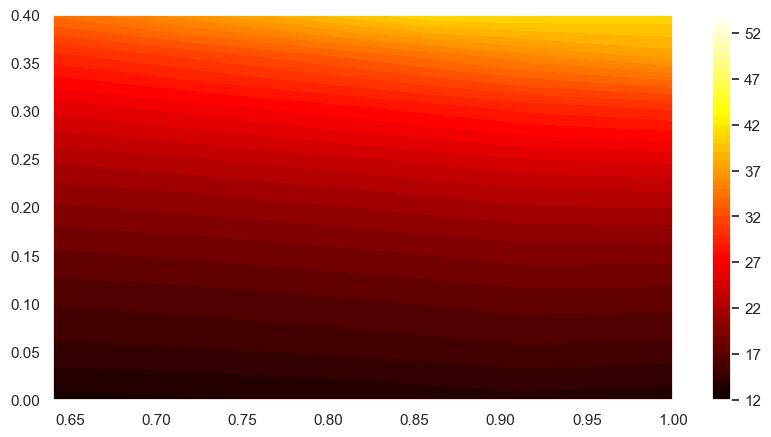

In [33]:
heat=df_hm_los.loc[:,['D1','D2','Losses']]
heat=heat.set_index('D2')
heat=heat.pivot(columns='D1')
heat_val=heat.values
D1_x=heat.columns.get_level_values(1)
D2_y=heat.index.values

fig, ax = plt.subplots()
#Plot the surface.
gr=ax.contourf(D1_x, D2_y, heat_val, 50, cmap='hot')#,vmin=6.9,vmax=30)  #'RdYlBu'
cbar=fig.colorbar(gr)
# ticklabs = cbar.ax.get_yticklabels()
# cbar.ax.set_yticklabels(ticklabs, fontsize=20)
# fig.canvas.toolbar_visible = True
# fig.canvas.header_visible = True
# fig.canvas.resizable = True

# Black lines -> max and min gain
#ax.plot(D1_r,D2_f(Vsa_max,Vbus,D1_r),'k')
#ax.plot(D1_r,D2_f(Vsa_min,Vbus,D1_r),'k')

# White lines-> limit the duty cyles due to dead times

#ax.plot(D1_r,D2_f(Vbus,Lim_sup_D1*Vbus,D1_r),'w')
#ax.plot(D1_f(Vbus*(1-Lim_inf_D2),Vbus,D2_r),D2_r,'w')


#ax.plot(D1_r,D2_r,'g')
plt.xlim(0.64,1)
plt.ylim(0,0.4)
# plt.xticks(fontsize = 20)
# plt.yticks(fontsize = 20)
# f = plt.figure()
# f.set_figwidth(20)
# f.set_figheight(10)


plt.show()




In [15]:
heat_val
 

array([[12.63528833, 12.68545485, 12.8480969 , 12.95746615, 13.15312466,
        13.38259094, 13.64491837, 13.35804058],
       [14.66200609, 14.73473366, 14.94072419, 15.07151471, 15.29890925,
        15.5602055 , 15.85349355, 15.64550608],
       [16.20266306, 16.3048404 , 16.56695775, 16.72521158, 16.9939461 ,
        17.2962748 , 17.63206034, 17.51479595],
       [18.03381621, 18.18313714, 18.53415327, 18.73684606, 19.07135418,
        19.4411365 , 19.84594661, 19.85821586],
       [20.23396207, 20.45517272, 20.94664431, 21.21851846, 21.66113075,
        22.14135039, 22.65223059, 22.86167764],
       [21.96163629, 22.25212698, 22.87800779, 23.2187297 , 23.77000588,
        24.35422291, 24.97428202, 25.3758077 ],
       [25.09419847, 25.53451406, 26.46445475, 26.96482895, 27.75166152,
        28.58110416, 29.45860696, 30.31696882],
       [29.13011026, 29.81110636, 31.24348684, 32.00220295, 33.1987147 ,
        34.46755189, 35.8188931 , 37.5313304 ],
       [34.61154927, 35.70419456

MEASUREMETNS

C:\Users\PC\AppData\Local\Temp\ipykernel_24056\3342910136.py:28: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour = plt.contourf(np.unique(d1), np.unique(d2),losses_rearr,70,cmap='hot', linewidth=0)


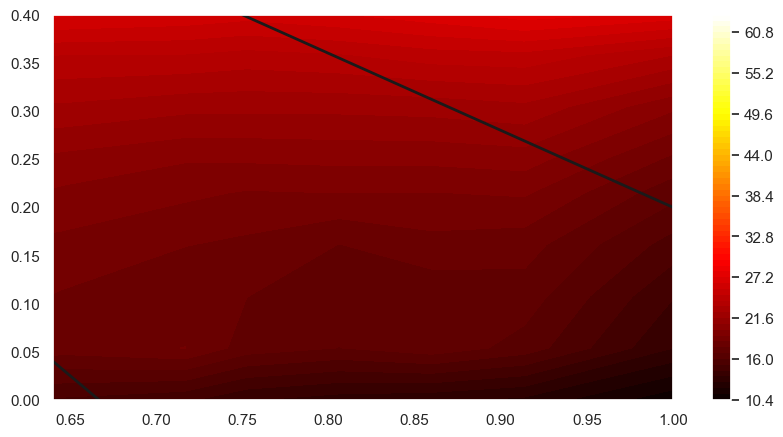

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV file
CSVM = pd.read_csv("Measurements\Bbheatmap3.csv", delimiter=';')
vout = CSV['vout']
iout = CSV['iout']
vin = CSV['vin']
iin = CSV['iin']
d1 = CSV['d1']
d2 = CSV['d2']

# Calculate additional parameters
pin = vin * iin
pout = iout * vout
losses = pin - pout
CSV['pin'] = pin
CSV['pout'] = pout
CSV['losses'] = losses
CSV = CSV[['vin', 'iin', 'iout', 'vout', 'd1', 'd2', 'pin', 'pout', 'losses']]
CSV.to_excel("output_data2.xlsx", index=False)
# Reshape losses array
losses_rearr = np.reshape(losses.to_numpy(), (len(np.unique(d1)), len(np.unique(d2))))
losses_rearr=losses_rearr.T
# Create contour plot
plt.figure()
contour = plt.contourf(np.unique(d1), np.unique(d2),losses_rearr,70,cmap='hot', linewidth=0)
plt.colorbar()

# Plot additional lines
d1b = np.linspace(np.min(np.unique(d1)), np.max(np.unique(d1)))
d2b = 1 - (d1b * 80 / 100)
plt.plot(d1b, d2b, 'k', linewidth=2)
d2b = 1 - (d1b * 150 / 100)
plt.plot(d1b, d2b, 'k', linewidth=2)

# Set axis limits
plt.axis([0.64,1,0, 0.4])

# Set colorbar range
#plt.clim(6.9, 30)

# Show the plot
plt.show()

df_th_meas['Meas. losses']=losses


In [20]:
#df_th_meas=df_th_meas.drop(['Loss diff_norm','Meas. losses_norm','Loss diff_norm','Meas. losses2','Loss diff2','Loss diff_norm2'],axis=1)
df_th_meas['Loss diff']=df_th_meas['Meas. losses']-df_th_meas['Theoretical losses']
df_th_meas['Loss diff_norm']=df_th_meas['Meas. losses']/df_th_meas['Meas. losses'].max()
df_th_meas['Theoretical losses_norm']=df_th_meas['Theoretical losses']/df_th_meas['Meas. losses'].max()
df_th_meas['Meas. losses_norm']=df_th_meas['Meas. losses']/df_th_meas['Meas. losses'].max()
df_th_meas['Loss diff_norm']=df_th_meas['Loss diff']/df_th_meas['Meas. losses'].max()
df_th_meas['Meas. losses2']=(df_th_meas['Meas. losses']-df_th_meas['Loss diff'].min())
df_th_meas['Meas. losses2_norm']=(df_th_meas['Meas. losses']-df_th_meas['Loss diff'].min())/df_th_meas['Meas. losses2'].max()
df_th_meas['Loss diff2']=(df_th_meas['Loss diff']-df_th_meas['Loss diff'].min())
df_th_meas['Theoretical losses_norm2']=df_th_meas['Theoretical losses']/df_th_meas['Meas. losses2'].max()
df_th_meas['Loss diff_norm2']=df_th_meas['Loss diff2']/df_th_meas['Meas. losses2'].max()
df_th_meas['Loss diff_norm3']=df_th_meas['Loss diff2']/df_th_meas['Meas. losses2'].max()
df_th_meas['Theoretical losses_norm3']=df_th_meas['Theoretical losses']/df_th_meas['Theoretical losses'].max()
df_th_meas['Meas. losses_norm3']=(df_th_meas['Meas. losses']-df_th_meas['Loss diff'].min())/df_th_meas['Meas. losses2'].max()
print(df_th_meas['Loss diff'].min())
df_th_meas

-16.06199072499082


,D1,D2,Theoretical losses,Meas. losses,Loss diff,Loss diff_norm,Theoretical losses_norm,Meas. losses_norm,Meas. losses2,Meas. losses2_norm,Loss diff2,Theoretical losses_norm2,Loss diff_norm2,Loss diff_norm3,Theoretical losses_norm3,Meas. losses_norm3
0,0.6091,0.0000,12.635288,15.267888,2.632600,0.042054,0.201840,0.243894,31.329879,0.398283,18.694590,0.160627,0.237656,0.237656,0.234057,0.398283
1,0.6091,0.0538,14.662006,18.407344,3.745338,0.059829,0.234216,0.294045,34.469335,0.438193,19.807329,0.186392,0.251802,0.251802,0.271600,0.438193
2,0.6091,0.1075,16.202663,18.693812,2.491149,0.039794,0.258827,0.298621,34.755803,0.441835,18.553140,0.205977,0.235858,0.235858,0.300140,0.441835
3,0.6091,0.1613,18.033816,19.148166,1.114350,0.017801,0.288078,0.305879,35.210157,0.447611,17.176341,0.229256,0.218355,0.218355,0.334060,0.447611
4,0.6091,0.2151,20.233962,20.251035,0.017073,0.000273,0.323224,0.323497,36.313026,0.461631,16.079064,0.257225,0.204406,0.204406,0.374816,0.461631
5,0.6091,0.2509,21.961636,20.841812,-1.119824,-0.017888,0.350823,0.332934,36.903803,0.469142,14.942166,0.279189,0.189953,0.189953,0.406819,0.469142
6,0.6091,0.3047,25.094198,22.303759,-2.790439,-0.044575,0.400863,0.356288,38.365750,0.487727,13.271551,0.319011,0.168715,0.168715,0.464847,0.487727
7,0.6091,0.3584,29.130110,24.275122,-4.854988,-0.077555,0.465334,0.387779,40.337113,0.512788,11.207002,0.370318,0.142470,0.142470,0.539609,0.512788
8,0.6091,0.4122,34.611549,27.657576,-6.953973,-0.111085,0.552897,0.441812,43.719567,0.555788,9.108017,0.440001,0.115786,0.115786,0.641147,0.555788
9,0.6091,0.4650,42.382652,32.967999,-9.414653,-0.150393,0.677035,0.526642,49.029990,0.623297,6.647338,0.538792,0.084505,0.084505,0.785100,0.623297


C:\Users\PC\AppData\Local\Temp\ipykernel_24056\1554933354.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour = plt.contourf(np.unique(df_th_meas['D1']),np.unique(df_th_meas['D2']),losses_rearro2,70,cmap='hot', linewidth=0)


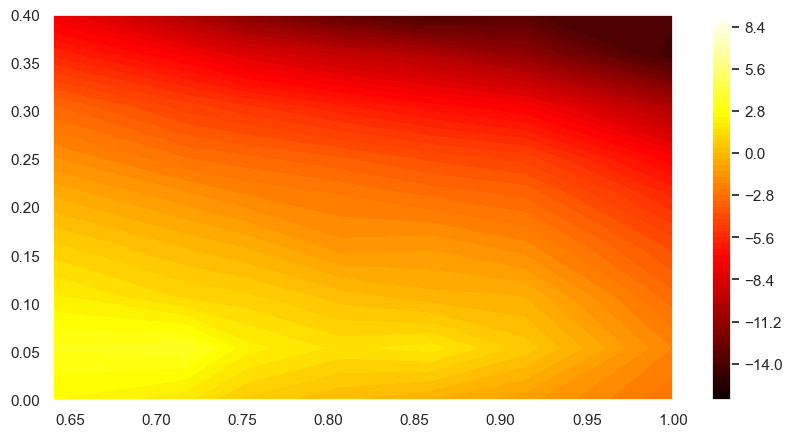

In [31]:
# losses_rearro = np.reshape(df_th_meas['Theoretical losses'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
# losses_rearro=losses_rearro.T
# contour = plt.contourf(np.unique(df_th_meas['D1']),np.unique(df_th_meas['D2']),losses_rearro,70,cmap='hot', linewidth=0)
# plt.colorbar()

# # Set axis limits
# plt.axis([0.64,1,0, 0.4])

# # Set colorbar range
# plt.clim(6.9, 30)

losses_rearro2 = np.reshape(df_th_meas['Loss diff'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro2=losses_rearro2.T
contour = plt.contourf(np.unique(df_th_meas['D1']),np.unique(df_th_meas['D2']),losses_rearro2,70,cmap='hot', linewidth=0)
plt.axis([0.64,1,0, 0.4])
plt.colorbar()

# Set colorbar range
#plt.clim(6.9, 30)

C:\Users\PC\AppData\Local\Temp\ipykernel_24056\3167086206.py:5: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour = plt.contourf(np.unique(df_th_meas['D1']),np.unique(df_th_meas['D2']),losses_rearro,70,cmap='hot', linewidth=0)


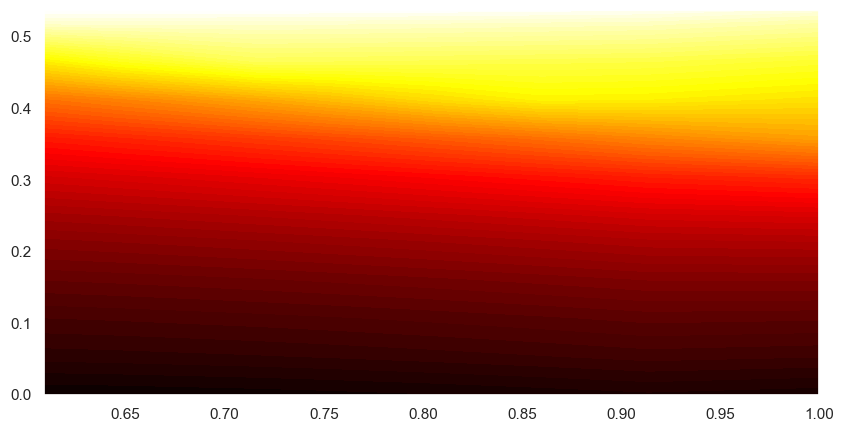

In [22]:
#reploteamos todo pero con la escala de colorbar del measured
#Teorico
losses_rearro = np.reshape(df_th_meas['Theoretical losses'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro=losses_rearro.T
contour = plt.contourf(np.unique(df_th_meas['D1']),np.unique(df_th_meas['D2']),losses_rearro,70,cmap='hot', linewidth=0)


C:\Users\PC\AppData\Local\Temp\ipykernel_24056\3575228825.py:12: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour1 = axs[0].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro, 70, cmap='hot', linewidth=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_24056\3575228825.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour2 = axs[1].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro2, 70, cmap='hot', linewidth=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_24056\3575228825.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


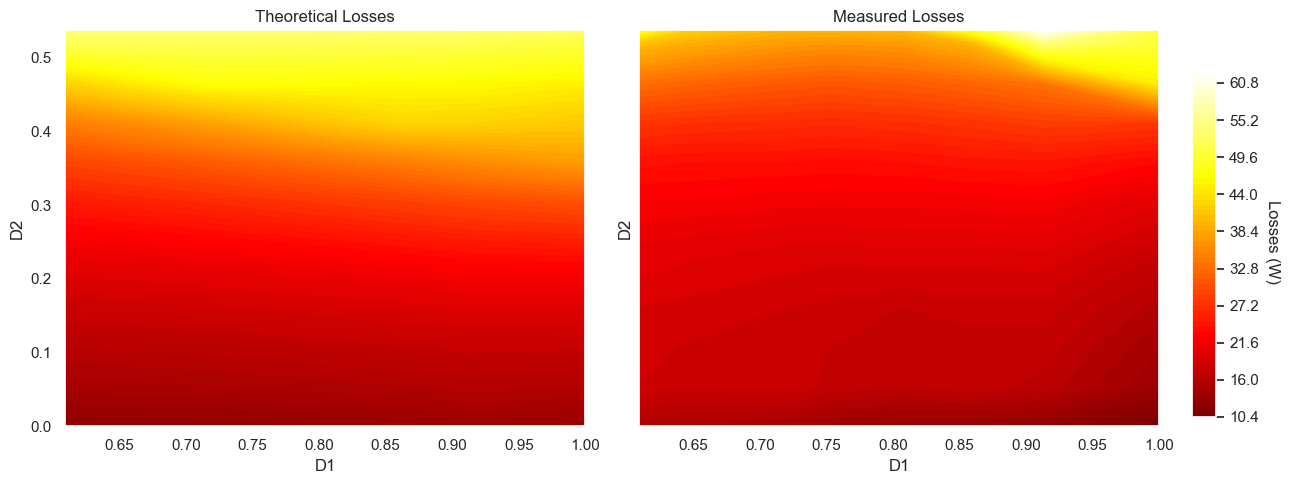

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have df_th_meas DataFrame and necessary data

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot the first contourf in the first subplot
losses_rearro = np.reshape(df_th_meas['Theoretical losses'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro = losses_rearro.T
contour1 = axs[0].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro, 70, cmap='hot', linewidth=0)
axs[0].set_title('Theoretical Losses')
axs[0].set_xlabel('D1')
axs[0].set_ylabel('D2')

# Plot the second contourf in the second subplot
losses_rearro2 = np.reshape(df_th_meas['Meas. losses'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro2 = losses_rearro2.T
contour2 = axs[1].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro2, 70, cmap='hot', linewidth=0)
axs[1].set_title('Measured Losses')
axs[1].set_xlabel('D1')
axs[1].set_ylabel('D2')

# Determine the common color limits based on the maximum values
max_value = max(losses_rearro.max(), losses_rearro2.max())

# Set color limits for both subplots
contour1.set_clim(0, max_value)
contour2.set_clim(0, max_value)

# Create a single colorbar on the right side
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(contour2, cax=cbar_ax, orientation='vertical')

# Add a title to the colorbar
cbar.set_label('Losses (W)', rotation=270, labelpad=15)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()



C:\Users\PC\AppData\Local\Temp\ipykernel_24056\2776750915.py:12: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour1 = axs[0].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro, 70, cmap='hot', linewidth=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_24056\2776750915.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour2 = axs[1].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro2, 70, cmap='hot', linewidth=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_24056\2776750915.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


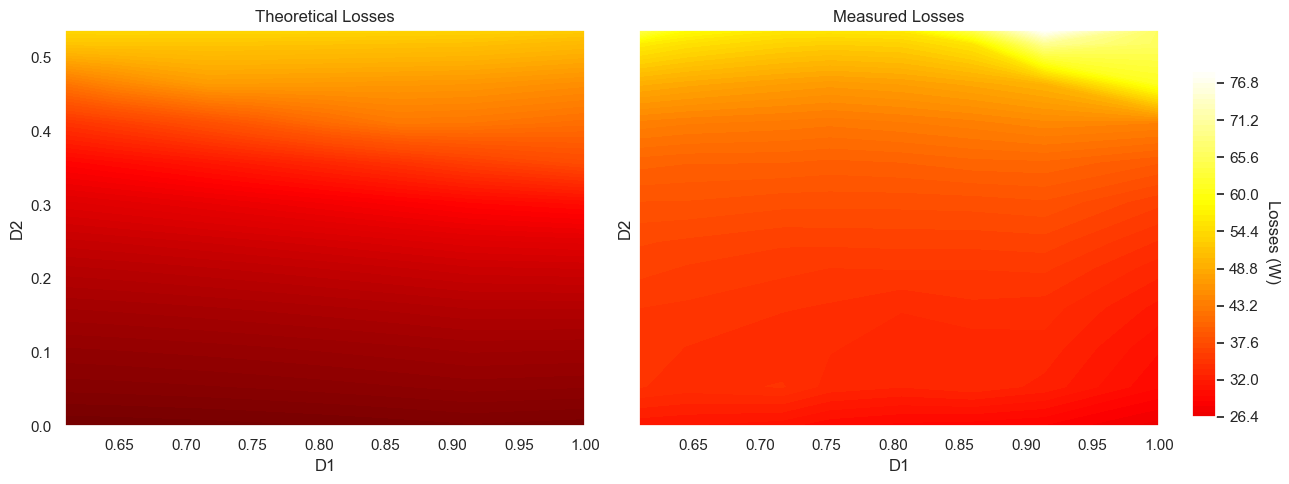

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have df_th_meas DataFrame and necessary data

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot the first contourf in the first subplot
losses_rearro = np.reshape(df_th_meas['Theoretical losses'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro = losses_rearro.T
contour1 = axs[0].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro, 70, cmap='hot', linewidth=0)
axs[0].set_title('Theoretical Losses')
axs[0].set_xlabel('D1')
axs[0].set_ylabel('D2')

# Plot the second contourf in the second subplot
losses_rearro2 = np.reshape(df_th_meas['Meas. losses2'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro2 = losses_rearro2.T
contour2 = axs[1].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro2, 70, cmap='hot', linewidth=0)
axs[1].set_title('Measured Losses')
axs[1].set_xlabel('D1')
axs[1].set_ylabel('D2')

# Determine the common color limits based on the maximum values
max_value = max(losses_rearro.max(), losses_rearro2.max())

# Set color limits for both subplots
contour1.set_clim(0, max_value)
contour2.set_clim(0, max_value)

# Create a single colorbar on the right side
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(contour2, cax=cbar_ax, orientation='vertical')

# Add a title to the colorbar
cbar.set_label('Losses (W)', rotation=270, labelpad=15)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_24056\1271746399.py:12: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour1 = axs[0].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro, 70, cmap='hot', linewidth=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_24056\1271746399.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour2 = axs[1].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro2, 70, cmap='hot', linewidth=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_24056\1271746399.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


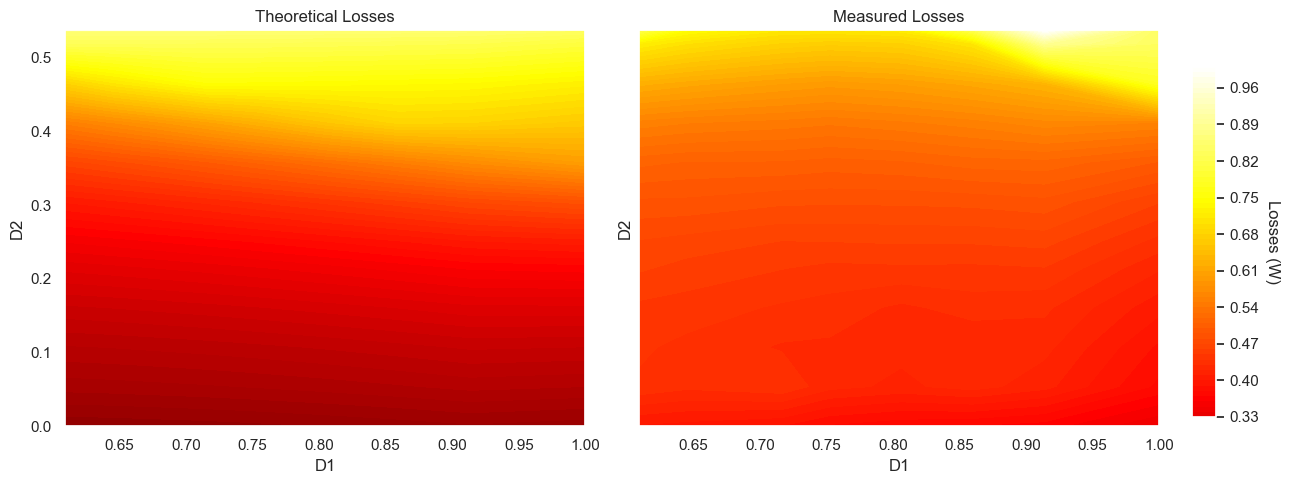

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have df_th_meas DataFrame and necessary data

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot the first contourf in the first subplot
losses_rearro = np.reshape(df_th_meas['Theoretical losses_norm'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro = losses_rearro.T
contour1 = axs[0].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro, 70, cmap='hot', linewidth=0)
axs[0].set_title('Theoretical Losses')
axs[0].set_xlabel('D1')
axs[0].set_ylabel('D2')

# Plot the second contourf in the second subplot
losses_rearro2 = np.reshape(df_th_meas['Meas. losses2_norm'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro2 = losses_rearro2.T
contour2 = axs[1].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro2, 70, cmap='hot', linewidth=0)
axs[1].set_title('Measured Losses')
axs[1].set_xlabel('D1')
axs[1].set_ylabel('D2')

# Determine the common color limits based on the maximum values
max_value = max(losses_rearro.max(), losses_rearro2.max())

# Set color limits for both subplots
contour1.set_clim(0, max_value)
contour2.set_clim(0, max_value)

# Create a single colorbar on the right side
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(contour2, cax=cbar_ax, orientation='vertical')

# Add a title to the colorbar
cbar.set_label('Losses (W)', rotation=270, labelpad=15)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_24056\1815040440.py:12: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour1 = axs[0].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro, 100, cmap='hot', linewidth=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_24056\1815040440.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour2 = axs[1].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro2, 100, cmap='hot', linewidth=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_24056\1815040440.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


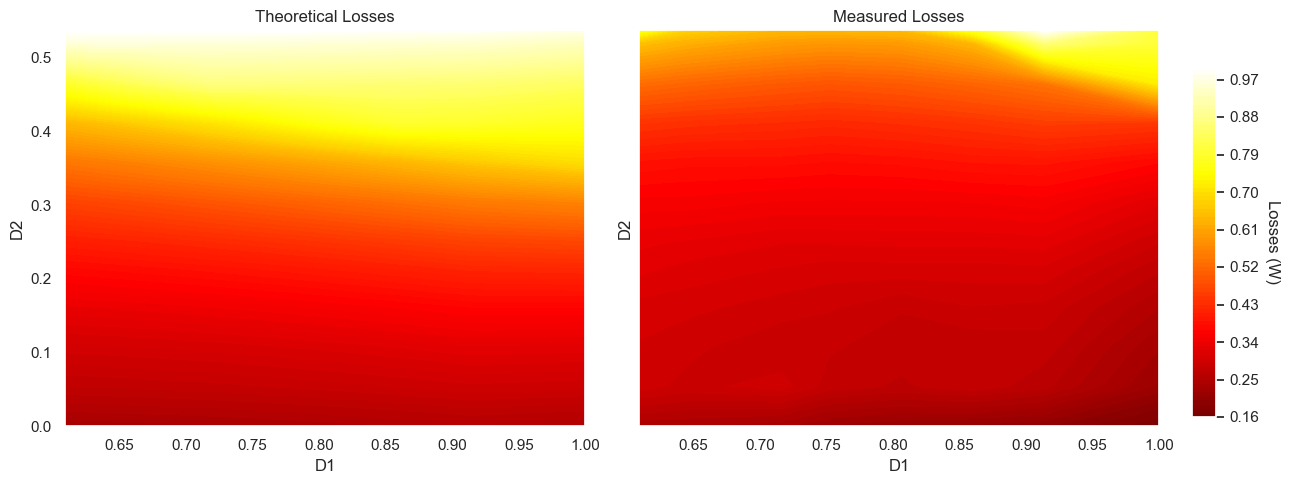

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have df_th_meas DataFrame and necessary data

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot the first contourf in the first subplot
losses_rearro = np.reshape(df_th_meas['Theoretical losses_norm3'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro = losses_rearro.T
contour1 = axs[0].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro, 100, cmap='hot', linewidth=0)
axs[0].set_title('Theoretical Losses')
axs[0].set_xlabel('D1')
axs[0].set_ylabel('D2')

# Plot the second contourf in the second subplot
losses_rearro2 = np.reshape(df_th_meas['Meas. losses_norm'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro2 = losses_rearro2.T
contour2 = axs[1].contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro2, 100, cmap='hot', linewidth=0)
axs[1].set_title('Measured Losses')
axs[1].set_xlabel('D1')
axs[1].set_ylabel('D2')

# Determine the common color limits based on the maximum values
max_value = max(losses_rearro.max(), losses_rearro2.max())

# Set color limits for both subplots
contour1.set_clim(0, losses_rearro.max())
contour2.set_clim(0, losses_rearro2.max())

# Create a single colorbar on the right side
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(contour2, cax=cbar_ax, orientation='vertical')

# Add a title to the colorbar
cbar.set_label('Losses (W)', rotation=270, labelpad=15)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_24056\3889895956.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour1 = plt.contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro1, 100, cmap='hot', linewidth=0)


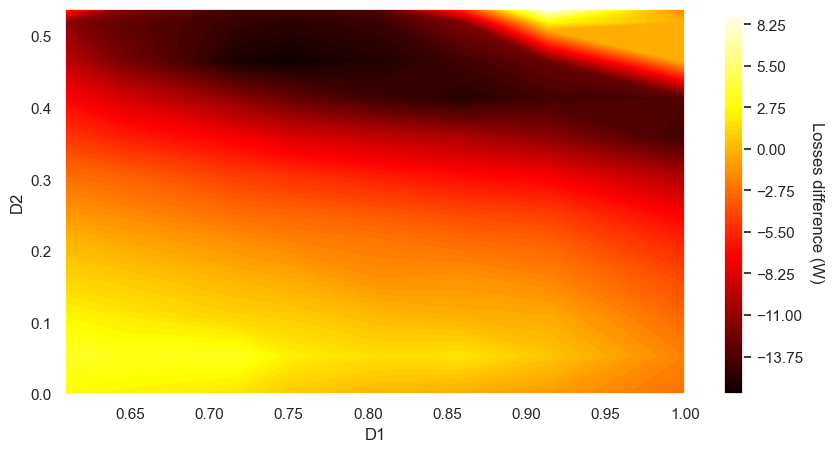

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have df_th_meas DataFrame and necessary data

# Plot the first contourf
losses_rearro1 = np.reshape(df_th_meas['Loss diff'].to_numpy(), (len(np.unique(df_th_meas['D1'])), len(np.unique(df_th_meas['D2']))))
losses_rearro1 = losses_rearro1.T
contour1 = plt.contourf(np.unique(df_th_meas['D1']), np.unique(df_th_meas['D2']), losses_rearro1, 100, cmap='hot', linewidth=0)

plt.xlabel('D1')
plt.ylabel('D2')

# Create a colorbar for the first plot
cbar1 = plt.colorbar(contour1, orientation='vertical')
cbar1.set_label('Losses difference (W)', rotation=270, labelpad=15)

# Show the first plot
plt.show()




## HEATMAP WITH MASK

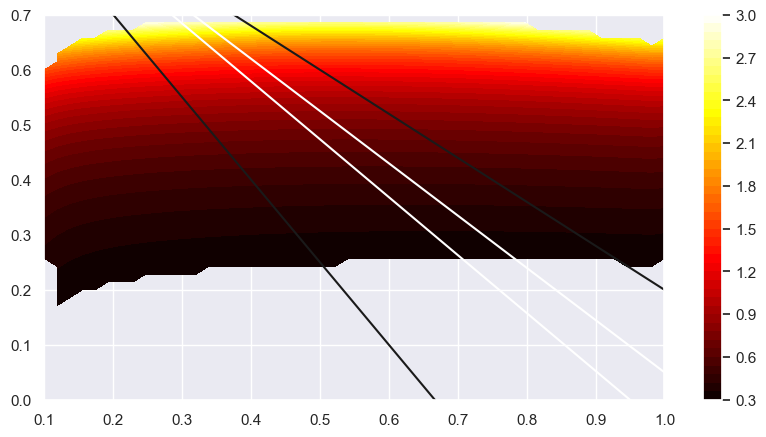

In [ ]:
fig, ax = plt.subplots()
#añadir protection mosfets OJO
phi_bob=phi*np.ones(df_hm.shape[0])
c=currents_L(df_hm['L'],df_hm['Vin'],Vbus,df_hm['Iin(A)'],D1_r,D2_r,phi_bob,T)
interv=intervals(D1_r,D2_r,phi_bob,T)
intervdf=pd.DataFrame(interv[-1])
df_hm_los1=df_hm.copy()
Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1_r,D2_r,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
aux_M1_1,Temp_M1_1=Losses_M1(D1_r,Vin_f(Vbus,D1_r,D2_r),c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,max_age,Rjc_M1,Rca_M1,Tini,Tjmax_M1,df_hm_los1)
aux_M2_1,Temp_M2_1=Losses_M2(D1_r,Vin_f(Vbus,D1_r,D2_r),c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,max_age,Rjc_M2,Rca_M2,Tini,Tjmax_M2,df_hm_los1)
aux_M3_1,Temp_M3_1=Losses_M3(D2_r,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,max_age,Rjc_M3,Rca_M3,Tini,Tjmax_M3,df_hm_los1)
aux_M4_1,Temp_M4_1=Losses_M4(D2_r,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,max_age,Rjc_M4,Rca_M4,Tini,Tjmax_M4,df_hm_los1)

Iac_ind=c[-1].max(axis=1)-c[-1].min(axis=1) #Validated with other implementation. Works

df_hm_los1['Iac_ind']=Iac_ind
Iavg_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
Irms1=Irms_sec(1/T,interv[2],interv[1],c[0],c[3])
Irms2=Irms_sec(1/T,interv[5],interv[4],c[1],c[0])
Irms3=Irms_sec(1/T,interv[8],interv[7],c[2],c[1])
Irms4=Irms_sec(1/T,interv[11],interv[10],c[3],c[2])
Irms_ind=np.sqrt(Irms1**2+Irms2**2+Irms3**2+Irms4**2)

df_hm_los1['Irms_ind']=Irms_ind
df_hm_los1['Ipk_ind']=c[-1].max(axis=1)
df_hm_los1['Iavg']=(c[-1].max(axis=1)+c[-1].min(axis=1))/2
aux_L_1=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
aux1=aux_M1_1+aux_M2_1+aux_M3_1+aux_M4_1+aux_L_1-aux
losses_1=aux_M1_1+aux_M2_1+aux_M3_1+aux_M4_1+aux_L_1
loss_difference=aux1
df_hm_los1['Losses']=df_hm_los['Losses']
df_hm_los1['Losses_aged']=losses_1
df_hm_los1['Loss_diff']=loss_difference
df_hm_los1['aux_M1']=aux_M1_1
df_hm_los1['aux_M2']=aux_M2_1
df_hm_los1['aux_M3']=aux_M3_1
df_hm_los1['aux_M4']=aux_M4_1
df_hm_los1['aux_L']=aux_L_1
df_hm_los1['Temp_M1']=Temp_M1_1
df_hm_los1['Temp_M2']=Temp_M2_1
df_hm_los1['Temp_M3']=Temp_M3_1
df_hm_los1['Temp_M4']=Temp_M4_1
df_hm_los1['Small losses']=df_hm_los1['Loss_diff'].mask((df_hm_los1['Loss_diff']<0.5)|(df_hm_los1['Temp_M1']>70)|(df_hm_los1['Temp_M2']>70)|(df_hm_los1['Temp_M3']>70)|(df_hm_los1['Temp_M4']>70) )

heat=df_hm_los1.loc[:,['D1','D2','Loss_diff']]
heat=heat.set_index('D2')
heat=heat.pivot(columns='D1')
heat_val=heat.values
D1_x=heat.columns.get_level_values(1)
D2_y=heat.index.values

impossible_values=df_hm_los1.loc[:,['D1','D2','Small losses']]
impossible_values=impossible_values.set_index('D2')
impossible_values=impossible_values.pivot(columns='D1')
impossible_values_val=impossible_values.values
D1_x=impossible_values.columns.get_level_values(1)
D2_y=impossible_values.index.values

#Plot the surface.
# gr=ax.contourf(D1_x, D2_y, heat_val, 50, cmap='coolwarm')#,vmin=6.9,vmax=30)  #'RdYlBu'
# fig.colorbar(gr)

gr_imp=ax.contourf(D1_x, D2_y, impossible_values_val, 50, cmap='hot',corner_mask=True)#,vmin=6.9,vmax=30)  #'RdYlBu'
# gr_imp=ax.contour(D1_x, D2_y, impossible_values_val, 50, colors='k')
fig.colorbar(gr_imp)
# cbar=fig.colorbar(gr_imp)
# ticklabs = cbar.ax.get_yticklabels()
# cbar.ax.set_yticklabels(ticklabs, fontsize=20)

# Las líneas negras representan las parejas de puntos que dan la mínima y máxima ganancia necesarias.
ax.plot(D1_r,D2_f(Vsa_max,Vbus,D1_r),'k')
ax.plot(D1_r,D2_f(Vsa_min,Vbus,D1_r),'k')

# Las líneas blancas representan la ganancia máxima que podría alcanzarse si se imponen límites del 0.95 a D1 y D2.
# Es decir, se puede fijar un D de 1 o menor de 0.95,pero nunca entre ambos valores por provlemas con retrassos, tiempos
#muertos, etc.

ax.plot(D1_r,D2_f(Vbus,Lim_sup_D1*Vbus,D1_r),'w')
ax.plot(D1_f(Vbus*(1-Lim_inf_D2),Vbus,D2_r),D2_r,'w')


#ax.plot(D1_r,D2_r,'g')
plt.xlim(D1_min_sh,D1_max_sh)
plt.ylim(D2_min_sh,D2_max_sh)
# plt.xticks(fontsize = 20)
# plt.yticks(fontsize = 20)

# f = plt.figure()
# f.set_figwidth(10)
# f.set_figheight(5)

plt.show()



In [ ]:
heat

Loss_diff                                                    \
D1        0.100000  0.118367  0.136735  0.155102  0.173469  0.191837   
D2                                                                     
0.000000  0.248096  0.228599  0.216037  0.207292  0.200886  0.196194   
0.014286  0.254688  0.234963  0.222461  0.213678  0.207314  0.202419   
0.028571  0.260242  0.240549  0.227996  0.219170  0.212686  0.207837   
0.042857  0.266142  0.246397  0.233706  0.224935  0.218419  0.213536   
0.057143  0.272398  0.252605  0.239994  0.230976  0.224447  0.219457   
0.071429  0.278682  0.258975  0.246233  0.237321  0.230744  0.225815   
0.085714  0.285298  0.265628  0.252876  0.243914  0.237428  0.232264   
0.100000  0.292163  0.272510  0.259645  0.250815  0.244412  0.239153   
0.114286  0.299067  0.279681  0.266836  0.258025  0.251500  0.246341   
0.128571  0.306439  0.287078  0.274454  0.265539  0.259140  0.253978   
0.142857  0.314179  0.294693  0.282136  0.273384  0.266879  0.261925   
0.157143  0.322493  0.302831  0.290383  0.281503  0.275285  0.270206   
0.171429  0.331022  0.311585  0.298993  0.290270  0.283805  0.278755   
0.185714  0.340399  0.320583  0.307956  0.299337  0.292977  0.288116   
0.200000  0.350018  0.330342  0.317627  0.308873  0.302504  0.297539   
0.214286  0.360572  0.340711  0.327968  0.319168  0.312619  0.307677   
0.228571  0.371562  0.351841  0.338893  0.329974  0.323499  0.318447   
0.242857  0.383527  0.363583  0.350556  0.341537  0.335172  0.329981   
0.257143  0.396276  0.376032  0.363018  0.354024  0.347318  0.342187   
0.271429  0.409843  0.389450  0.376337  0.367149  0.360611  0.355338   
0.285714  0.424498  0.403982  0.390551  0.381394  0.374664  0.369316   
0.300000  0.439949  0.419477  0.406140  0.396721  0.389696  0.384358   
0.314286  0.457163  0.436145  0.422549  0.413003  0.405967  0.400634   
0.328571  0.475264  0.454196  0.440345  0.430844  0.423357  0.418103   
0.342857  0.495120  0.473629  0.459498  0.449704  0.442470  0.436653   
0.357143  0.516492  0.494769  0.480474  0.470399  0.462878  0.457016   
0.371429  0.539842  0.517653  0.503007  0.492792  0.484839  0.478865   
0.385714  0.565088  0.542591  0.527546  0.517048  0.509146  0.502840   
0.400000  0.592714  0.569766  0.554396  0.543595  0.535204  0.528949   
0.414286  0.623128  0.599337  0.583727  0.572273  0.564088  0.557277   
0.428571  0.656333  0.631778  0.616012  0.604065  0.595344  0.588441   
0.442857  0.693025  0.668012  0.651250  0.639188  0.630044  0.622862   
0.457143  0.733786  0.707762  0.690343  0.677731  0.667828  0.660223   
0.471429  0.778686  0.751869  0.733432  0.720582  0.710234  0.701644   
0.485714  0.828754  0.801035  0.781904  0.767598  0.756965  0.748511   
0.500000  0.884881  0.856056  0.835629  0.820785  0.809244  0.799883   
0.514286  0.947922  0.917214  0.895992  0.880647  0.868241  0.857665   
0.528571  1.019582  0.986963  0.964172  0.947892  0.934406  0.923116   
0.542857  1.100972  1.066512  1.042279  1.024110  1.009572  0.997364   
0.557143  1.194277  1.157019  1.131322  1.111471  1.095669  1.081875   
0.571429  1.301554  1.261636  1.233776  1.212021  1.194201  1.179312   
0.585714  1.427517  1.384337  1.353151  1.328707  1.308832  1.291975   
0.600000  1.575258  1.527303  1.492893  1.465381  1.443349  1.423906   
0.614286  1.751208  1.698555  1.659280  1.628201  1.602517  1.580149   
0.628571  1.964215  1.904519  1.858921  1.823487  1.793658  1.767596   
0.642857  2.225054  2.156270  2.104173  2.061390  2.025591  1.994269   
0.657143  2.550560  2.469464  2.407706  2.356429  2.313449  2.275089   
0.671429  2.966294  2.869443  2.793474  2.730044  2.676977  2.629523   
0.685714  3.510841  3.390731  3.296288  3.216374  3.148944  3.087800   
0.700000  4.250749  4.096866  3.972823  3.868061  3.777206  3.697329   

                                                                      \
D1        0.210204  0.228571  0.246939  0.265306  0.283673  0.302041   
D2                                              

In [ ]:
impossible_values




Small losses                                                    \
D1           0.100000  0.118367  0.136735  0.155102  0.173469  0.191837   
D2                                                                        
0.000000          NaN       NaN       NaN       NaN       NaN       NaN   
0.014286          NaN       NaN       NaN       NaN       NaN       NaN   
0.028571          NaN       NaN       NaN       NaN       NaN       NaN   
0.042857          NaN       NaN       NaN       NaN       NaN       NaN   
0.057143          NaN       NaN       NaN       NaN       NaN       NaN   
0.071429          NaN       NaN       NaN       NaN       NaN       NaN   
0.085714          NaN       NaN       NaN       NaN       NaN       NaN   
0.100000          NaN       NaN       NaN       NaN       NaN       NaN   
0.114286          NaN       NaN       NaN       NaN       NaN       NaN   
0.128571          NaN       NaN       NaN       NaN       NaN       NaN   
0.142857          NaN       NaN       NaN       NaN       NaN       NaN   
0.157143          NaN  0.302831       NaN       NaN       NaN       NaN   
0.171429          NaN  0.311585       NaN       NaN       NaN       NaN   
0.185714          NaN  0.320583  0.307956       NaN       NaN       NaN   
0.200000          NaN  0.330342  0.317627  0.308873  0.302504       NaN   
0.214286          NaN  0.340711  0.327968  0.319168  0.312619  0.307677   
0.228571          NaN  0.351841  0.338893  0.329974  0.323499  0.318447   
0.242857          NaN  0.363583  0.350556  0.341537  0.335172  0.329981   
0.257143     0.396276  0.376032  0.363018  0.354024  0.347318  0.342187   
0.271429     0.409843  0.389450  0.376337  0.367149  0.360611  0.355338   
0.285714     0.424498  0.403982  0.390551  0.381394  0.374664  0.369316   
0.300000     0.439949  0.419477  0.406140  0.396721  0.389696  0.384358   
0.314286     0.457163  0.436145  0.422549  0.413003  0.405967  0.400634   
0.328571     0.475264  0.454196  0.440345  0.430844  0.423357  0.418103   
0.342857     0.495120  0.473629  0.459498  0.449704  0.442470  0.436653   
0.357143     0.516492  0.494769  0.480474  0.470399  0.462878  0.457016   
0.371429     0.539842  0.517653  0.503007  0.492792  0.484839  0.478865   
0.385714     0.565088  0.542591  0.527546  0.517048  0.509146  0.502840   
0.400000     0.592714  0.569766  0.554396  0.543595  0.535204  0.528949   
0.414286     0.623128  0.599337  0.583727  0.572273  0.564088  0.557277   
0.428571     0.656333  0.631778  0.616012  0.604065  0.595344  0.588441   
0.442857     0.693025  0.668012  0.651250  0.639188  0.630044  0.622862   
0.457143     0.733786  0.707762  0.690343  0.677731  0.667828  0.660223   
0.471429     0.778686  0.751869  0.733432  0.720582  0.710234  0.701644   
0.485714     0.828754  0.801035  0.781904  0.767598  0.756965  0.748511   
0.500000     0.884881  0.856056  0.835629  0.820785  0.809244  0.799883   
0.514286     0.947922  0.917214  0.895992  0.880647  0.868241  0.857665   
0.528571     1.019582  0.986963  0.964172  0.947892  0.934406  0.923116   
0.542857     1.100972  1.066512  1.042279  1.024110  1.009572  0.997364   
0.557143     1.194277  1.157019  1.131322  1.111471  1.095669  1.081875   
0.571429     1.301554  1.261636  1.233776  1.212021  1.194201  1.179312   
0.585714     1.427517  1.384337  1.353151  1.328707  1.308832  1.291975   
0.600000     1.575258  1.527303  1.492893  1.465381  1.443349  1.423906   
0.614286          NaN  1.698555  1.659280  1.628201  1.602517  1.580149   
0.628571          NaN  1.904519  1.858921  1.823487  1.793658  1.767596   
0.642857          NaN       NaN  2.104173  2.061390  2.025591  1.994269   
0.657143          NaN       NaN       NaN  2.356429  2.313449  2.275089   
0.671429          NaN       NaN       NaN       NaN       NaN  2.629523   
0.685714          NaN       NaN       NaN       NaN       NaN       NaN   
0.700000          NaN       NaN       NaN       NaN       NaN       NaN   

                                 

NEW DEFINITION OF VARIABLES

In [10]:
gain_min=Vbus/Vsa_max
gain_max=Vbus/Vsa_min
gain_vert=D1_max/(1-0) #Máxima ganancia que se puede conseguir operando con D2=0 (modo Buck)
gain_horz=1/(1-D2_min) #Mínima ganancia que se puede conseguir operando con D1=1 (modo Boost)


In [1]:
elements=30

In [11]:
L_ind=83.5e-6
i=0
losses=[0 for i in range(elements)]
gainr=np.linspace(gain_min,gain_max,elements)
phi_bob=0.4*0
phi_bob=phi_bob*np.ones(elements)
D1x=np.where(gainr<gain_vert,gainr,np.where(gainr<gain_horz,D1_max,1))
D2x=np.where(gainr<gain_vert,0,1-D1x/gainr)
Vbus=Vbus
Vin=Vbus/gainr
fsw=180000
T=1/fsw
#We create a dataframe and add the different values
df=pd.DataFrame(columns=['Gain','D1','D2'])
df['Gain']=gainr
df['D1']=D1x
df['D2']=D2x
df['phi']=phi_bob*np.ones(df.shape[0])
df['T']=T*np.ones(df.shape[0])
df['fsw']=fsw*np.ones(df.shape[0])
df['L']=L_ind*np.ones(df.shape[0])
df['Vin']=Vbus*np.ones(df.shape[0])/gainr
df['Vbus']=Vbus*np.ones(df.shape[0])
df['P']=P*np.ones(df.shape[0])
df['Iin(A)']=P/(Vbus/gainr)
# df_Gain=df.set_index('Gain')
Iin=df['Iin(A)'].to_numpy()


#change to multiindex with D1 and D2 because this way it would be easier to develop the heatmap
indexmap=pd.MultiIndex.from_arrays([df['D1'],df['D2']],names=('D1','D2'))
df1mi=df.copy()#If not copied the original can be modified
df1mi=df1mi.drop(columns=['D1','D2'])
df1mi.index=indexmap
pd.Series(indexmap.get_level_values(0)) #If I use d1 and d2 as multiindex, it is to get those indexes to use them in t1

c=currents_L(df['L'],df['Vin'],Vbus,df['Iin(A)'],D1x,D2x,phi_bob,T)

interv=intervals(D1x,D2x,phi_bob,T)
intervdf=pd.DataFrame(interv[-1])
Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1x,D2x,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
aux_M1=Losses_M1(D1x,Vbus/gainr,c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging,Rjc_M1,Rca_M1,Tini,Tjmax_M1,df)
aux_M2=Losses_M2(D1x,Vbus/gainr,c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging,Rjc_M2,Rca_M2,Tini,Tjmax_M2,df)
aux_M3=Losses_M3(D2x,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging,Rjc_M3,Rca_M3,Tini,Tjmax_M3,df)
aux_M4=Losses_M4(D2x,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging,Rjc_M4,Rca_M4,Tini,Tjmax_M4,df)
Iac_ind=c[-1].max(axis=1)-c[-1].min(axis=1) #Validated with other implementation. Works
df_los=df.copy()
df_los['Iac_ind']=Iac_ind
Iavg_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
Irms1=Irms_sec(1/T,interv[2],interv[1],c[0],c[3])
Irms2=Irms_sec(1/T,interv[5],interv[4],c[1],c[0])
Irms3=Irms_sec(1/T,interv[8],interv[7],c[2],c[1])
Irms4=Irms_sec(1/T,interv[11],interv[10],c[3],c[2])
Irms_ind=np.sqrt(Irms1**2+Irms2**2+Irms3**2+Irms4**2)
df_los['Irms_ind']=Irms_ind
df_los['Ipk_ind']=c[-1].max(axis=1)
df_los['Iavg']=(c[-1].max(axis=1)+c[-1].min(axis=1))/2
aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
aux=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
losses=aux
df_los['Losses']=losses
df_los['aux_M1']=aux_M1
df_los['aux_M2']=aux_M2
df_los['aux_M3']=aux_M3
df_los['aux_M4']=aux_M4
df_los['aux_L']=aux_L
# interv[-1]
# c[-1]
# interv
plt.plot(interv[-1].loc[0,'t1_0':'t1_49'], Ip1(interv[-1].iloc[0,0:50],L_ind,df_los.loc[0,'Vin'],Vbus,c[-1].loc[0,'Ip4_end'],phi_bob[0],D1x[0],D2x[0]),'blue')
plt.plot(interv[-1].iloc[0,52:102],Ip2(interv[-1].iloc[0,52:102]-interv[-1].iloc[0,51],L_ind,df_los.loc[0,'Vin'],Vbus,c[-1].loc[0,'Ip1_end'],phi_bob[0],D1x[0],D2x[0]),'red')
plt.plot(interv[-1].iloc[0,104:154],Ip3(interv[-1].iloc[0,104:154]-interv[-1].iloc[0,103],L_ind,df_los.loc[0,'Vin'],Vbus,c[-1].loc[0,'Ip2_end'],phi_bob[0],D1x[0],D2x[0]),'orange')
plt.plot(interv[-1].iloc[0,156:206],Ip4(interv[-1].iloc[0,156:206]-interv[-1].iloc[0,155],L_ind,df_los.loc[0,'Vin'],Vbus,c[-1].loc[0,'Ip3_end'],phi_bob[0],D1x[0],D2x[0]),'green')
plt.show()
df_los.head() 




ValueError: Length of values (8) does not match length of index (30)

ANNEX: RMS VALUE VALIDATION

In [ ]:
# c[-1].min(axis=1)
voboost=100
ioutboost=5
vsboost=80
dutyboost=(voboost-vsboost)/voboost
periodoboost=1/180000
inducboost=83.5e-6

Iavgboost=voboost*ioutboost/vsboost
Iripboost=(vsboost*dutyboost)*periodoboost/inducboost
iminboost=Iavgboost-Iripboost/2
Irmsboost=(np.sqrt(iminboost*iminboost+iminboost*Iripboost+Iripboost*Iripboost/3))
Irmsboost2=np.sqrt(Iavgboost*Iavgboost+Iripboost*Iripboost/12)
print('Iavg',Iavgboost)
print('Irms',Irmsboost)
print('irip',Iripboost)
print('Ipk', iminboost+Iripboost)
print('Irmsboost',Irmsboost2)

Iavg 6.25
Irms 6.257550374572053
irip 1.0645375914836994
Ipk 6.7822687957418495
Irmsboost2 6.257550374572052


In [ ]:
vobuck=100
ioutbuck=5
vsbuck=150
dutybuc=(vobuck/vsbuck)
periodobuck=1/180000
inducbuck=83.5e-6

ioutbuck=500/vobuck
Iavgbuck=ioutbuck
Iripbuck=(vsbuck-vobuck)*periodobuck*dutybuc/inducbuck
iminbuck=Iavgbuck-Iripbuck/2
Irmsbuck=(np.sqrt(iminbuck*iminbuck+iminbuck*Iripbuck+Iripbuck*Iripbuck/3))
Irmsbuck2=np.sqrt(Iavgbuck*Iavgbuck+Iripbuck*Iripbuck/12)
print('Iavg',Iavgbuck)
print('Irms',Irmsbuck)
print('irip',Iripbuck)
print('Ipk', iminbuck+Iripbuck)
print('Irmsbuck',Irmsbuck2)

Iavg 5.0
Irms 5.040821507288827
irip 2.2177866489243736
Ipk 6.108893324462187
Irmsbuck2 5.040821507288827


MATRIZ-MODEL

In [12]:
from itertools import product
values = list(product(range(aging_steps), range(aging_steps), range(aging_steps),range(aging_steps),gainr)) #to get all possible combinations
dfrds=pd.DataFrame(values)
dfrds.columns=['iRds1','iRds2','iRds3','iRds4','Gain']
df_aged=pd.merge(dfrds,df)
c=currents_L(df_aged['L'],df_aged['Vin'],df_aged['Vbus'],df_aged['Iin(A)'],df_aged['D1'],df_aged['D2'],df_aged['phi'],df_aged['T'])
interv=intervals(df_aged['D1'],df_aged['D2'],df_aged['phi'],df_aged['T'])
Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(df_aged['D1'],df_aged['D2'],df_aged['phi'],1/df_aged['T'],interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
g=df_aged['iRds1']
aux_M1=Losses_M1(df_aged['D1'],df_aged['Vin'],c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,1+g/aging_steps*aging_max)
h=df_aged['iRds2']
aux_M2=Losses_M2(df_aged['D1'],df_aged['Vin'],c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,1+h/aging_steps*aging_max)
i=df_aged['iRds3']
aux_M3=Losses_M3(df_aged['D2'],df_aged['Vbus'],c[2],c[0],1/df_aged['T'],M3_index,Vdrvr,Idrvr,Irms_M3,1+i/aging_steps*aging_max)
j=df_aged['iRds4']
aux_M4=Losses_M4(df_aged['D2'],df_aged['Vbus'],c[0],c[2],1/df_aged['T'],M4_index,Vdrvr,Idrvr,Irms_M4,1+j/aging_steps*aging_max)
Iac_ind=c[-1].max(axis=1)-c[-1].min(axis=1) 
dfrds['Iac_ind']=Iac_ind
Irms_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])
df_aged['Irms_ind']=Irms_ind
df_aged['Ipk_ind']=c[-1].max(axis=1)

aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)
losses_aged=aux_M1+aux_M2+aux_M3+aux_M4+aux_L
df_aged['Losses aged']=losses_aged #Este es el aging data del codgio de manu

fig, ax = plt.subplots()

ax.plot(df_aged.loc[(df_aged['iRds1']==0)&(df_aged['iRds2']==0)&(df_aged['iRds3']==0)&(df_aged['iRds4']==0),'Gain'],df_aged.loc[(df_aged['iRds1']==0)&(df_aged['iRds2']==0)&(df_aged['iRds3']==0)&(df_aged['iRds4']==0),'Losses aged'],'y')
ax.plot(df_aged.loc[(df_aged['iRds1']==1)&(df_aged['iRds2']==0)&(df_aged['iRds3']==0)&(df_aged['iRds4']==0),'Gain'],df_aged.loc[(df_aged['iRds1']==1)&(df_aged['iRds2']==1)&(df_aged['iRds3']==1)&(df_aged['iRds4']==1),'Losses aged'],'k')
ax.plot(df_aged.loc[(df_aged['iRds1']==2)&(df_aged['iRds2']==0)&(df_aged['iRds3']==0)&(df_aged['iRds4']==0),'Gain'],df_aged.loc[(df_aged['iRds1']==2)&(df_aged['iRds2']==2)&(df_aged['iRds3']==2)&(df_aged['iRds4']==2),'Losses aged'],'g')
ax.plot(df_aged.loc[(df_aged['iRds1']==3)&(df_aged['iRds2']==3)&(df_aged['iRds3']==0)&(df_aged['iRds4']==0),'Gain'],df_aged.loc[(df_aged['iRds1']==3)&(df_aged['iRds2']==3)&(df_aged['iRds3']==3)&(df_aged['iRds4']==3),'Losses aged'],'r')
# Ya tengo una base de datos con todos los posibles valores de pérdidas en función del envejecimiento de cada MOSFET.
# aux1[age_MOSFET1][age_MOSFET2][age_MOSFET3][Age_MOSFET4][gain]
# Se tienen n edades de envejecimiento para cada MOSFET

#repeat what was done with the other 

def aging_estimation(coef_1_ini,coef_2_ini,coef_3_ini,coef_4_ini,error,df_losses):
    muestra_r=[0 for sample in range(df_losses.shape[0])]
    muestra=[0 for sample in range(df_losses.shape[0])]
    losses_not_damaged=[]
    df_not_damaged=pd.DataFrame()
    # Se toma una muestra de la diferencia entre un convertidor sano y uno envejecido según los coeficientes de arriba (muestra)
    # y la misma muestra con errores aleatorios (muestra_r) debido a medida con un máximo de (error%)
    for gain in df_losses['Gain'].unique():#variación de Gain
        #print("gain is:", gain)
        losses_not_damaged=np.append(losses_not_damaged,df_losses.loc[(df_losses['iRds1']==0)&(df_losses['iRds2']==0)&(df_losses['iRds3']==0)&(df_losses['iRds4']==0)& (df_losses['Gain']==gain),'Losses aged'])
    df_not_damaged['Gain']=df_losses['Gain'].unique()
    df_not_damaged['Losses not damaged']=losses_not_damaged
    df_losses=pd.merge(df_losses,df_not_damaged)
    df_losses['Diff_losses']=df_losses.loc[:,'Losses aged']-df_losses['Losses not damaged']
    df_losses['Diff_losses noise']=df_losses['Diff_losses']*(1+random.randint(-error, error)/1000)
    
    error_ind=((df_losses['Diff_losses noise']-df_losses['Diff_losses'])**2)
    df_losses['MSE_single']=error_ind 

    # Se busca por mínimos cuadrados la combinación de coefficentes que más aproximan el modelo a la muestra con errores de medición a
    # Es importante resaltar  Mque no se ha hecho con el modelo matemático, sino explorando la matrix de reusltados que se han sacado
    # con el modelo. Básicamente es lo mismo, pero sería bueno explorar si a partir de las ecuaciones se puede ganar algo.

    values_dummy=pd.DataFrame()

    r_valores = np.array(list(product(df_losses['iRds1'].unique(),df_losses['iRds2'].unique(), df_losses['iRds3'].unique(),df_losses['iRds4'].unique())))
    MSE=np.zeros(r_valores.shape[0]) 
    #Me quedo con todas las ocurrencias 
    for i in range(r_valores.shape[0]):
        sel_aging=df_aged.loc[(df_losses['iRds1']==r_valores[i][0])&(df_losses['iRds2']==r_valores[i][1])&(df_losses['iRds3']==r_valores[i][2])&(df_losses['iRds4']==r_valores[i][3])]

        suma_MSE=sel_aging['MSE_single'].sum()
        MSE[i]=(suma_MSE)#/(r_valores.shape[0])
    values_dummy['iRds1','iRds2','iRds3','iRds4','MSE']=r_valores[:,0],r_valores[:,1],r_valores[:,2],r_valores[:,3],MSE

    df_losses=pd.merge(df_losses,values_dummy)
    coef_1_out,coef_2_out,coef_3_out,coef_4_out=df_losses[df_losses['MSE']==df_losses['MSE'].min(),['iRds1','iRds2','iRds3','iRds4']] 
    return coef_1_out,coef_2_out,coef_3_out,coef_4_out,muestra,muestra_r


TypeError: Losses_M1() missing 5 required positional arguments: 'Rjc', 'Rca', 'Tini', 'Tmax', and 'df'

In [ ]:
# MSE=np.zeros(r_valores.shape[0])
# r_valores=np.array(r_valores)
# for i in range(r_valores.shape[0]):
#     sel_aging=df_aged.loc[(df_aged['iRds1']==r_valores[i][0])&(df_aged['iRds2']==r_valores[i][1])&(df_aged['iRds3']==r_valores[i][2])&(df_aged['iRds4']==r_valores[i][3])]
#     MSE[i]=sel_aging['Losses aged'].sum() 
# MSE

In [ ]:
# sel_aging

In [ ]:
coef_1_ini=5
coef_2_ini=2
coef_3_ini=2
coef_4_ini=5

# muestra_r=[0 for gainr in range(elements)]
# muestra=[0 for gainr in range(elements)]
df_losses=df_aged.copy()
error=error_sense
# df_aged2=aging_estimation(coef_1_ini,coef_2_ini,coef_3_ini,coef_4_ini,error_sense,df_aged)
# df_aged2
# coef_1,coef_2,coef_3,coef_4,muestra,muestra_r=aging_estimation2(df_aged2)


muestra_r=[0 for sample in range(df_losses.shape[0])]
muestra=[0 for sample in range(df_losses.shape[0])]
losses_not_damaged=[]
df_not_damaged=pd.DataFrame()
    # Se toma una muestra de la diferencia entre un convertidor sano y uno envejecido según los coeficientes de arriba (muestra)
    # y la misma muestra con errores aleatorios (muestra_r) debido a medida con un máximo de (error%)
for gain in df_losses['Gain'].unique():#variación de Gain
       #print("gain is:", gain)
    losses_not_damaged=np.append(losses_not_damaged,df_losses.loc[(df_losses['iRds1']==0)&(df_losses['iRds2']==0)&(df_losses['iRds3']==0)&(df_losses['iRds4']==0)& (df_losses['Gain']==gain),'Losses aged'])
df_not_damaged['Gain']=df_losses['Gain'].unique()
df_not_damaged['Losses not damaged']=losses_not_damaged
df_losses=pd.merge(df_losses,df_not_damaged)
df_losses['Diff_losses']=df_losses.loc[:,'Losses aged']-df_losses['Losses not damaged']
df_losses['Diff_losses noise']=df_losses['Diff_losses']*(1+random.randint(-error, error)/1000)
    
error_ind=((df_losses['Diff_losses noise']-df_losses['Diff_losses'])**2)
df_losses['MSE_single']=error_ind 

    # Se busca por mínimos cuadrados la combinación de coefficentes que más aproximan el modelo a la muestra con errores de medición a
    # Es importante resaltar  Mque no se ha hecho con el modelo matemático, sino explorando la matrix de reusltados que se han sacado
    # con el modelo. Básicamente es lo mismo, pero sería bueno explorar si a partir de las ecuaciones se puede ganar algo.

values_dummy=pd.DataFrame()

r_valores = np.array(list(product(df_losses['iRds1'].unique(),df_losses['iRds2'].unique(), df_losses['iRds3'].unique(),df_losses['iRds4'].unique())))
MSE=np.zeros(r_valores.shape[0]) 
    #Me quedo con todas las ocurrencias 
for i in range(r_valores.shape[0]):
    sel_aging=df_aged.loc[(df_losses['iRds1']==r_valores[i][0])&(df_losses['iRds2']==r_valores[i][1])&(df_losses['iRds3']==r_valores[i][2])&(df_losses['iRds4']==r_valores[i][3])]

    suma_MSE=sel_aging['MSE_single'].sum()
    MSE[i]=(suma_MSE)#/(r_valores.shape[0])
values_dummy['iRds1']=r_valores[:,0]
values_dummy['iRds2']=r_valores[:,1]
values_dummy['iRds3']=r_valores[:,2]
values_dummy['iRds4']=r_valores[:,3]
values_dummy['MSE']=MSE

df_losses=pd.merge(df_losses,values_dummy)
df_losses=df_losses.drop(df_losses[df_losses['MSE']==0].index)
coef_1_out,coef_2_out,coef_3_out,coef_4_out=df_losses.loc[df_losses['MSE']==df_losses['MSE'].min(),['iRds1','iRds2','iRds3','iRds4']] 
df_losses.loc[df_losses['MSE']==df_losses['MSE'].min()]

,iRds1,iRds2,iRds3,iRds4,Gain,D1,D2,phi,T,fsw,L,Vin,Vbus,P,Iin(A),Irms_ind,Ipk_ind,Losses aged,Losses not damaged,Diff_losses,Diff_losses noise,MSE_single,MSE
30,0,0,0,1,0.666667,0.666667,0.000000,0.0,0.000006,180000.0,0.000083,150.000000,100.0,500.0,3.333333,5.000000,6.108893,3.901844,3.901844,0.000000,0.000000,0.000000e+00,1.268736e-07
31,0,0,0,1,0.686782,0.686782,0.000000,0.0,0.000006,180000.0,0.000083,145.606695,100.0,500.0,3.433908,5.000000,6.041977,3.853533,3.853533,0.000000,0.000000,0.000000e+00,1.268736e-07
32,0,0,0,1,0.706897,0.706897,0.000000,0.0,0.000006,180000.0,0.000083,141.463415,100.0,500.0,3.534483,5.000000,5.975061,3.809243,3.809243,0.000000,0.000000,0.000000e+00,1.268736e-07
33,0,0,0,1,0.727011,0.727011,0.000000,0.0,0.000006,180000.0,0.000083,137.549407,100.0,500.0,3.635057,5.000000,5.908145,3.768624,3.768624,0.000000,0.000000,0.000000e+00,1.268736e-07
34,0,0,0,1,0.747126,0.747126,0.000000,0.0,0.000006,180000.0,0.000083,133.846154,100.0,500.0,3.735632,5.000000,5.841229,3.731363,3.731363,0.000000,0.000000,0.000000e+00,1.268736e-07
35,0,0,0,1,0.767241,0.767241,0.000000,0.0,0.000006,180000.0,0.000083,130.337079,100.0,500.0,3.836207,5.000000,5.774313,3.697181,3.697181,0.000000,0.000000,0.000000e+00,1.268736e-07
36,0,0,0,1,0.787356,0.787356,0.000000,0.0,0.000006,180000.0,0.000083,127.007299,100.0,500.0,3.936782,5.000000,5.707397,3.665824,3.665824,0.000000,0.000000,0.000000e+00,1.268736e-07
37,0,0,0,1,0.807471,0.807471,0.000000,0.0,0.000006,180000.0,0.000083,123.843416,100.0,500.0,4.037356,5.000000,5.640481,3.637063,3.637063,0.000000,0.000000,0.000000e+00,1.268736e-07
38,0,0,0,1,0.827586,0.827586,0.000000,0.0,0.000006,180000.0,0.000083,120.833333,100.0,500.0,4.137931,5.000000,5.573566,3.610688,3.610688,0.000000,0.000000,0.000000e+00,1.268736e-07
39,0,0,0,1,0.847701,0.847701,0.000000,0.0,0.000006,180000.0,0.000083,117.966102,100.0,500.0,4.238506,5.000000,5.506650,3.586507,3.586507,0.000000,0.000000,0.000000e+00,1.268736e-07


In [ ]:
df_losses.loc[(df_losses['MSE']==df_losses['MSE'].min())&(df_losses['MSE']!=0),['Gain','iRds1','iRds2','iRds3','iRds4']] 

,Gain,iRds1,iRds2,iRds3,iRds4


In [ ]:
df_losses

NameError: name 'df_losses' is not defined

,iRds1,iRds2,iRds3,iRds4,Gain,D1,D2,phi,T,fsw,L,Vin,Vbus,P,Iin(A),Irms_ind,Ipk_ind,Losses aged,loss difference,Losses not damaged
0,0,0,0,0,0.666667,0.666667,0.0,0.0,0.000006,180000.0,0.000083,150.0,100.0,500.0,3.333333,5.00,6.108893,3.901844,0.000000,3.901844
1,0,0,0,1,0.666667,0.666667,0.0,0.0,0.000006,180000.0,0.000083,150.0,100.0,500.0,3.333333,5.00,6.108893,3.901844,0.000000,3.901844
2,0,0,0,2,0.666667,0.666667,0.0,0.0,0.000006,180000.0,0.000083,150.0,100.0,500.0,3.333333,5.00,6.108893,3.901844,0.000000,3.901844
3,0,0,0,3,0.666667,0.666667,0.0,0.0,0.000006,180000.0,0.000083,150.0,100.0,500.0,3.333333,5.00,6.108893,3.901844,0.000000,3.901844
4,0,0,0,4,0.666667,0.666667,0.0,0.0,0.000006,180000.0,0.000083,150.0,100.0,500.0,3.333333,5.00,6.108893,3.901844,0.000000,3.901844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38875,5,5,5,1,1.250000,1.000000,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.250000,6.25,6.782269,5.241094,1.339250,5.060972
38876,5,5,5,2,1.250000,1.000000,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.250000,6.25,6.782269,5.245010,1.343166,5.060972
38877,5,5,5,3,1.250000,1.000000,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.250000,6.25,6.782269,5.248925,1.347081,5.060972
38878,5,5,5,4,1.250000,1.000000,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.250000,6.25,6.782269,5.252841,1.350997,5.060972


,iRds1,iRds2,iRds3,iRds4,Gain,D1,D2,phi,T,fsw,L,Vin,Vbus,P,Iin(A),Irms_ind,Ipk_ind,Losses aged,loss difference
37584,0,0,0,0,1.25,1.0,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.25,6.25,6.782269,5.060972,1.159128
37585,0,0,0,1,1.25,1.0,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.25,6.25,6.782269,5.064888,1.163044
37586,0,0,0,2,1.25,1.0,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.25,6.25,6.782269,5.068804,1.166959
37587,0,0,0,3,1.25,1.0,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.25,6.25,6.782269,5.072719,1.170875
37588,0,0,0,4,1.25,1.0,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.25,6.25,6.782269,5.076635,1.174791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38875,5,5,5,1,1.25,1.0,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.25,6.25,6.782269,5.241094,1.339250
38876,5,5,5,2,1.25,1.0,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.25,6.25,6.782269,5.245010,1.343166
38877,5,5,5,3,1.25,1.0,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.25,6.25,6.782269,5.248925,1.347081
38878,5,5,5,4,1.25,1.0,0.2,0.0,0.000006,180000.0,0.000083,80.0,100.0,500.0,6.25,6.25,6.782269,5.252841,1.350997


Generacion base de datos para un perfil de ganancia (ya hecho)

masked_array(data=[1, 2, 3, --, 5],
             mask=[False, False, False,  True, False],
       fill_value=999999)